
Import the Libraries for Data Extraction, Processing, Visualization, Machine Learning etc. used in this Project

In [4]:
#Import the libraries needed for the Project
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report
from sklearn.utils import resample
import missingno as msno
from sklearn.manifold import TSNE
from xgboost import XGBClassifier, plot_importance
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier, StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from pandas.api.types import is_numeric_dtype
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
#Import the model metric for the classification problem 
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score,f1_score, confusion_matrix as cm
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
#To compute the mutual Information
from sklearn.feature_selection import mutual_info_classif
import re
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier, Pool
from sklearn import model_selection
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('test2png.png', dpi=100)

<Figure size 1332x756 with 0 Axes>

Construct a Class Named Machine to read the file, Perform some Feature Engineering, Machine Learning Etc.

In [5]:
#Construct the Machine Class for the Diabetes Prediction Project
class Machine:
    #Definre the Class constructor
    def __init__(self,):
        self.filename = pd.DataFrame()
        self.dataframe = pd.DataFrame()
  
    #Define a function that Extract the Diabetes Data from the system
    def load_file(self,filename):
        #Read the Diabetes Readmission file using the pandas library
        self.dataframe = pd.read_csv(filename)
        #Retrun the dataframe 
        return self.dataframe
   
    #Check if there is Nans in the  
    def check_nan(self, dataframe):
        ratio = 100/dataframe.shape[0]
        #Calculate the percentage missing value in each column
        nan = [(c, (dataframe[c].isna().sum() + dataframe[c]\
                         [dataframe[c] == '?'].count())*ratio) for c in \
            dataframe]
        self.nan = pd.DataFrame(nan, columns=["column_name", "percentage"])
        return self.nan
    
    #Define a function that returns the datatype of the dataset
    def data_type(self, col, max_cat=20):
        df = self.dataframe
        if (df[col].dtype == "O") | (df[col].nunique() < max_cat):
            return "categorical"
        else:
            return "numerical"
    
    # A function to visualize the missing values
    # Do not forget to add categories for ?
    def missing_visuals(self, dataset):
        #Replace ? as Nan to show the visualization of the total nans

        df = dataset.replace("?",np.nan)
        columns_dict = {col:self.data_type(col, max_cat=20) for col in df.columns}
        heatmap = df.isnull()
        for k,v in columns_dict.items():
            if v == "numerical":
                heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
            else:
                heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)
        sns.heatmap(heatmap, cbar=False).set_title('Dataset Overview')
        plt.show()
        print("\033[1;37;40m Categerocial ", "\033[1;30;41m Numeric ", "\033[1;30;47m NaN ")
       
    
     #Remove columns based on the number of NAs and ?s present
    def remove_wrong_columns(self, df):
        #allow only columns with less than 2 percent missing value.
        size = df.shape[0] * 0.02
        unclean = [c for c in df.columns 
            if (df[c].isna().sum() + df[c][df[c] == '?'].count() )> size]
        df = df.drop(unclean, axis = 1)
        df = df.drop(["encounter_id","patient_nbr"], axis = 1)
        #Remove columns with single data values. The only values of this features is one entry
        less_value = [c for c in df.columns 
            if (len(pd.unique(df[c]))) < 2]
        self.df = df.drop(less_value, axis = 1)
        return self.df
    #Replace the Nans using backward fill
    def data_cleaning(self, data): 
 
        #Replace ? as nan
        data = data.replace("?",np.nan)
        
        #Backward fill the Nans in the dataset
        data = data.fillna(method = "backfill", axis = 1)
        data = data.drop(data.loc[data["gender"]=="Unknown/Invalid"].index, axis=0)
        return data
    
      #A function that plots targeted categorical features including the target class  
    def category_plots(self, data, column):
        #Plot a barchart for the targeted feature using the seaborn countplot method
        sns.countplot(x = column, data = data,
            order = data[f"{column}"].value_counts().index)
        plt.xticks(rotation = 90)
        #Set the Title for the plot 
        plt.title("Distribution of {}".format(column))
        plt.show()

        # Pie chart
        data[column].value_counts().plot.pie(autopct = "%.1f%%")
        plt.title("Distriibution of Variable")
        plt.show()
    def area_plots(self, df, class_0, class_1, feature, xlabel):
        fig = plt.figure(figsize=(10,5))

        #readmitted = 0
        ax = sns.kdeplot(df.loc[(class_0), feature],
                 color = "b", shade = True, label = "Not Readmitted")

        ax = sns.kdeplot(df.loc[(class_1), feature],
                 color = "r", shade = True, label = "Readmitted")
        ax.legend(loc="upper right")

        ax.set_xlabel(xlabel)
        ax.set_ylabel("Frequency")
        ax.set_title(xlabel + " - Readmission")
        plt.show()
        
    #This function transforms the Diag1 - 3 features into meaningful entries based on the domain knowledge
    def transform_diagnosis(self, df, colnames):
        #Loop through the three columns and perform the preprocessing operation to group the dataset into appropriate categories
        for col in colnames:
            df.loc[(df[col].str.contains("V")) | (df[col].str.contains("E")), col] = -1
            df[col] = df[col].astype(np.float16)

        for col in colnames:
            df["temp_diag"] = np.nan
            df.loc[(df[col]>=390) & (df[col]<=459) | (df[col]==785), "temp_diag"] = "Circulatory"
            df.loc[(df[col]>=460) & (df[col]<=519) | (df[col]==786), "temp_diag"] = "Respiratory"
            df.loc[(df[col]>=520) & (df[col]<=579) | (df[col]==787), "temp_diag"] = "Digestive"
            df.loc[(df[col]>=250) & (df[col]<251), "temp_diag"] = "Diabetes"
            df.loc[(df[col]>=800) & (df[col]<=999), "temp_diag"] = "Injury"
            df.loc[(df[col]>=710) & (df[col]<=739), "temp_diag"] = "Musculoskeletal"
            df.loc[(df[col]>=580) & (df[col]<=629) | (df[col] == 788), "temp_diag"] = "Genitourinary"
            df.loc[(df[col]>=140) & (df[col]<=239), "temp_diag"] = "Neoplasms"

            df["temp_diag"] = df["temp_diag"].fillna("Other")
            df[col] = df["temp_diag"]
            df = df.drop("temp_diag", axis=1)
        return df  
    #Hand coded encoder that replaces some object (string) value with numerical values
    def encoded_data(self, data):
        meds = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide',\
                 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', \
                 'glyburide-metformin', 'tolazamide', 'metformin-pioglitazone','metformin-rosiglitazone', \
                 'glimepiride-pioglitazone', 'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide']
        numerical_columns = ['num_medications','time_in_hospital','num_lab_procedures', 'num_procedures',\
                             'number_outpatient','number_emergency','number_inpatient','number_diagnoses']
        data[numerical_columns] = data[numerical_columns].astype(str).astype('int64')
        for c in meds:
            data[c] = data[c].replace(['No','Steady','Up','Down'],[0,1,1,1])
            data[c] = data[c].astype('int64')
        #Change the data types of numerical variables 
        #Relace both admission values (<30 and >30) as 1 and No as 0
        readmission_map = {"NO":0,"<30":1,">30":1}
        data.readmitted = data.readmitted.replace(readmission_map)
        
        #Replace the value >200 and >300 as 2, Norm as 1, and None as 0
        glu_serum_map = {">200":2, ">300":2, "Norm":1,"None":0}
        data.max_glu_serum = data["max_glu_serum"].replace(glu_serum_map)
        

        #We decided use the A1c test result like as follows
        a1_cresult_map = {">7":2, ">8":2, "Norm":1, "None":0}
        data["A1Cresult"] = data.A1Cresult.replace(a1_cresult_map)
        return data
    
    #A function that plots the outliers in the dataset. This is only applicable to the numerical variables 
    def outlier_boxplot(self, data, features):
        counts = 0
        fig, ax =plt.subplots(nrows=2,ncols=4, figsize=(16,8))
        for i in range(2):
            for j in range(4):
                sns.boxplot(x = data[features[count]], palette="Wistia",ax=ax[i][j])
                counts = counts+1
    #To avoid in balance dataset, resample the target class too have the same number of data points.
    #This is done to avoid overgenralization that could lead to overfiting 
    def resample(self, X_t, Y_t):
        
        #To do this we concatinate (join) the X_train and Y_train data
        X = pd.concat([X_t, Y_t], axis=1)

        #Splot the data into readmitted and not_readmitted
        not_readmitted = X[X.readmitted==0]
        readmitted = X[X.readmitted==1]
        #
        not_readmitted_sampled = resample(not_readmitted,
                                replace = False, 
                                n_samples = len(readmitted),
                                random_state = 42)
        #Get the downsampled dataset sointaining equal datapoints for the two class
        downsampled = pd.concat([not_readmitted_sampled, readmitted])
        return downsampled
        
    #Define a function that calculates specificity based on the actual, predicted values and a threshold 
    def calc_specificity(self, y_actual, y_pred, thresh):
        # calculates specificity
        return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)
    
    #This function gives the complete report of the model
    #Performance Metrics like recall, accuracy, and fscore are printed and returned
    def model_report(self, y_actual, y_pred, thresh):
        #Get the auc 
        auc = roc_auc_score(y_actual, y_pred)
        #Get the model accuracy
        accuracy = accuracy_score(y_actual, (y_pred > thresh))
        #Get the model Recall
        recall = recall_score(y_actual, (y_pred > thresh))
        #Get the model precision
        precision = precision_score(y_actual, (y_pred > thresh))
        #Get the model fscore
        fscore = f1_score(y_actual,(y_pred > thresh) )
        #Get the model Specificity
        specificity = self.calc_specificity(y_actual, y_pred, thresh)
        #Print the three metrics
        print('AUC:%.3f'%auc)
        print('accuracy:%.3f'%accuracy)
        print('recall:%.3f'%recall)
        print('precision:%.3f'%precision)
        print('fscore:%.3f'%fscore)
        print('specificity:%.3f'%specificity)
        print(' ')
        #Return the metrics calculated into a list 
        return auc, accuracy, recall, precision,fscore, specificity
    
    #Define the confusion matrix function that plots the heatmap of the model to show the positives and negatives
    def confusion_mat(self, model, X_t, X_v, Y_t, Y_v):
        predictions = model.predict(X_t)
        train_score = round(accuracy_score(Y_t, predictions), 3)
        cm_train = cm(Y_t, predictions )
        predictions = model.predict(X_v)
        val_score = round(accuracy_score(Y_v, predictions), 3)
        cm_val = cm(Y_v, predictions)
        fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,5)) 
        sns.heatmap(cm_train, annot=True, fmt=".0f",ax=ax1)
        ax1.set_xlabel('Predicted Values')
        ax1.set_ylabel('Actual Values')
        ax1.set_title('Train Accuracy Score: {0}'.format(train_score), size = 15)
        sns.heatmap(cm_val, annot=True, fmt=".0f",ax=ax2)
        ax2.set_xlabel('Predicted Values')
        ax2.set_ylabel('Actual Values')
        ax2.set_title('Validation Accuracy Score: {0}'.format(val_score), size = 15)
        plt.show()
    #Define a table that plots performance metrics
    def metrics_table(self, metrics, data):
        #Get either the train or validation data metrics from the performance metrics
        df = metrics.loc[metrics['data_set'] == data]
        #sort the data and reset the index
        df = df.sort_values("auc").reset_index(drop=True)
    
        fig, axs =plt.subplots(2,1)
        axs[0].axis('tight')
        axs[0].axis('off')
        #plot the table
        the_table = axs[0].table(cellText=df.values,colLabels=df.columns,loc='center')
        plt.show()

    #Show the metrics of the classifiers to see the respective performance
    def show_metrics(self, metrics):
        fig, ax = plt.subplots(figsize=(10,6)) 
        ax = sns.barplot(x="classifier", y=metrics, hue="data_set", data=base_models_results)
        ax.set_xlabel('Classifier',fontsize = 15)
        ax.set_ylabel(metrics.upper(), fontsize = 15)
        ax.tick_params(labelsize=15)
        # Put the legend out of the figure
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)
        plt.show()
        
    #A function that compares the parameters
    def compare_parameters(self, classifier, base_model, tuned_model, train, val):
        y_train_preds_base = base_model.predict_proba(X_train)[:,1]
        y_val_preds_base = base_model.predict_proba(X_val)[:,1]
        print('Baseline ' + classifier)
        train_auc_base = roc_auc_score(y_train, y_train_preds_base)
        val_auc_base = roc_auc_score(y_val, y_val_preds_base)

        print('Training AUC:%.3f'%(train_auc_base))
        print('Validation AUC:%.3f'%(val_auc_base))

        print('Optimized' + classifier)
        y_train_preds = tuned_model.predict_proba(train)[:,1]
        y_val_preds = tuned_model.predict_proba(val)[:,1]

        train_auc = roc_auc_score(y_train, y_train_preds)
        val_auc = roc_auc_score(y_val, y_val_preds)

        print('Training AUC:%.3f'%(train_auc))
        print('Validation AUC:%.3f'%(val_auc))
        return train_auc_base, val_auc_base,  train_auc, val_auc
    
    #Calculate the test scores of the model
    def test_scores(self, y_actual, y_pred, thresh):
    
        auc = roc_auc_score(y_actual, y_pred)
        accuracy = accuracy_score(y_actual, (y_pred > thresh))
        recall = recall_score(y_actual, (y_pred > thresh))
    
        return auc, accuracy, recall

Create the Object from the class and pass the data in to read the Diabetes Readmission Data. 
Note: Ensure file Location is correct for the code to run Perfectly. ***Cheers***

In [6]:
#Location of the Diabetic csv file in the local computer


#Please ensure you change this location for the program to run
file = "C:/Users/PC/Desktop/Courses/Machine Learning/ICA/Eniola_Rahman/Dataset/diabetic_data.csv"
#create a data object from the Machine class
data_obj = Machine()
#Load the Diabetes Readmission file using the load_file method of the Machine Class
data_obj.load_file(file)

#Load the File into variable df (A pandas dataframe object)
df = data_obj.load_file(file)
dataset = data_obj.dataframe

#Set the environment to display the maximum column
pd.options.display.max_columns = None

#View five sample drawn from the dataset
dataset.sample(5)

encounter_id  patient_nbr             race  gender      age    weight  \
65251     181828446     42417819        Caucasian  Female   [0-10)         ?   
47453     145838238      5053059        Caucasian    Male  [70-80)  [75-100)   
99820     417913466     84721527        Caucasian  Female  [40-50)         ?   
82357     256521846     96228387  AfricanAmerican    Male  [40-50)         ?   
55170     159757632     56151216        Caucasian    Male  [50-60)         ?   

      admission_type_id                           discharge_disposition_id  \
65251         Emergency                                 Discharged to home   
47453          Elective                                 Discharged to home   
99820         Emergency  Discharged/transferred to another short term h...   
82357         Emergency                                 Discharged to home   
55170          Elective  Discharged/transferred to home with home healt...   

       admission_source_id  time_in_hospital payer_code  \
65251       Emergency Room                 2         SP   
47453   Physician Referral                 4         MC   
99820       Emergency Room                 4         HM   
82357       Emergency Room                 5         MC   
55170   Physician Referral                 3          ?   

                medical_specialty  num_lab_procedures  num_procedures  \
65251                           ?                  50               0   
47453             Surgery-General                  36               3   
99820                           ?                  64               0   
82357                           ?                  64               1   
55170  Orthopedics-Reconstructive                  11               1   

       num_medications  number_outpatient  number_emergency  number_inpatient  \
65251                8                  1                 1                 0   
47453               16                  3                 0                 0   
99820               26                  2                 0                 3   
82357               24                  2                 3                 0   
55170               17                  1                 0                 0   

       diag_1 diag_2 diag_3  number_diagnoses max_glu_serum A1Cresult  \
65251  250.11    276    276                 5          None        >7   
47453     189    V10    401                 6          None      None   
99820     493    276    278                 9          None      None   
82357   250.6    585    425                 9          None        >8   
55170     715    401    250                 3          None      None   

      metformin repaglinide nateglinide chlorpropamide glimepiride  \
65251        No          No          No             No          No   
47453        No          No          No             No          No   
99820        No          No          No             No      Steady   
82357        No          No          No             No          No   
55170      Down          No          No             No          No   

      acetohexamide glipizide glyburide tolbutamide pioglitazone  \
65251            No        No        No          No           No   
47453            No        No    Steady          No           No   
99820            No        No        No          No           No   
82357            No        No        No          No           No   
55170            No        No        No          No           No   

      rosiglitazone acarbose miglitol troglitazone tolazamide examide  \
65251            No       No       No           No         No      No   
47453            No       No       No           No         No      No   
99820            No       No       No           No         No      No   
82357            No       No       No           No         No      No   
55170            No       No       No           No         No      No   

      citoglipton insulin glyburide-metformin glipizide-metformin  \

***Data Exploration*** 
<br/>
This section is the start of Data Exploration Step. That is to understand the data and identify any issue that need to be sorted out. 

1. Use the ***pandas describe() method*** to get the statistics of the integer features in the dataset

In [7]:
#dataset description
dataset.describe()

encounter_id   patient_nbr  time_in_hospital  num_lab_procedures  \
count  1.017660e+05  1.017660e+05     101766.000000       101766.000000   
mean   1.652016e+08  5.433040e+07          4.395987           43.095641   
std    1.026403e+08  3.869636e+07          2.985108           19.674362   
min    1.252200e+04  1.350000e+02          1.000000            1.000000   
25%    8.496119e+07  2.341322e+07          2.000000           31.000000   
50%    1.523890e+08  4.550514e+07          4.000000           44.000000   
75%    2.302709e+08  8.754595e+07          6.000000           57.000000   
max    4.438672e+08  1.895026e+08         14.000000          132.000000   

       num_procedures  num_medications  number_outpatient  number_emergency  \
count   101766.000000    101766.000000      101766.000000     101766.000000   
mean         1.339730        16.021844           0.369357          0.197836   
std          1.705807         8.127566           1.267265          0.930472   
min          0.000000         1.000000           0.000000          0.000000   
25%          0.000000        10.000000           0.000000          0.000000   
50%          1.000000        15.000000           0.000000          0.000000   
75%          2.000000        20.000000           0.000000          0.000000   
max          6.000000        81.000000          42.000000         76.000000   

       number_inpatient  number_diagnoses  
count     101766.000000     101766.000000  
mean           0.635566          7.422607  
std            1.262863          1.933600  
min            0.000000          1.000000  
25%            0.000000          6.000000  
50%            0.000000          8.000000  
75%            1.000000          9.000000  
max           21.000000         16.000000

2. The ***Pandas info() method*** give us the summary of all features in the dataset including the missing value and the data type

In [8]:
#Get the summary of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         96475 non-null   object
 7   discharge_disposition_id  98075 non-null   object
 8   admission_source_id       94985 non-null   object
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

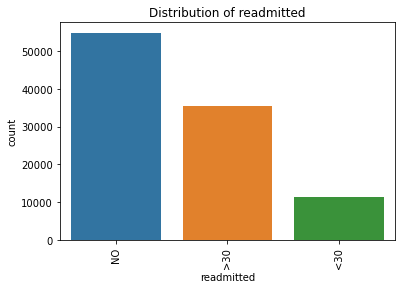

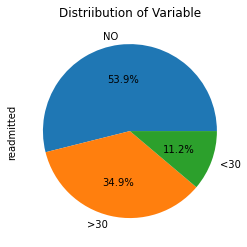

In [9]:
data_obj.category_plots(df, "readmitted")

3. The next step of the data exploration steps is to check for missing values using the ***check_nan() method***

In [10]:
#Check for the number of missing values in the dataset
data_obj.check_nan(df)

column_name  percentage
0               encounter_id    0.000000
1                patient_nbr    0.000000
2                       race    2.233555
3                     gender    0.000000
4                        age    0.000000
5                     weight   96.858479
6          admission_type_id    5.199182
7   discharge_disposition_id    3.626948
8        admission_source_id    6.663326
9           time_in_hospital    0.000000
10                payer_code   39.557416
11         medical_specialty   49.082208
12        num_lab_procedures    0.000000
13            num_procedures    0.000000
14           num_medications    0.000000
15         number_outpatient    0.000000
16          number_emergency    0.000000
17          number_inpatient    0.000000
18                    diag_1    0.020636
19                    diag_2    0.351787
20                    diag_3    1.398306
21          number_diagnoses    0.000000
22             max_glu_serum    0.000000
23                 A1Cresult    0.000000
24                 metformin    0.000000
25               repaglinide    0.000000
26               nateglinide    0.000000
27            chlorpropamide    0.000000
28               glimepiride    0.000000
29             acetohexamide    0.000000
30                 glipizide    0.000000
31                 glyburide    0.000000
32               tolbutamide    0.000000
33              pioglitazone    0.000000
34             rosiglitazone    0.000000
35                  acarbose    0.000000
36                  miglitol    0.000000
37              troglitazone    0.000000
38                tolazamide    0.000000
39                   examide    0.000000
40               citoglipton    0.000000
41                   insulin    0.000000
42       glyburide-metformin    0.000000
43       glipizide-metformin    0.000000
44  glimepiride-pioglitazone    0.000000
45   metformin-rosiglitazone    0.000000
46    metformin-pioglitazone    0.000000
47                    change    0.000000
48               diabetesMed    0.000000
49                readmitted    0.000000

4. From 3 above we observe that there are some missing value in the data, so we use the ***missing_visuals() method*** to plot the missing value and their respective data types

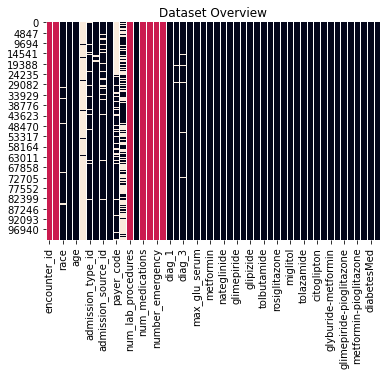

 Categerocial   Numeric   NaN 


In [11]:
#Plot the missing values
data_obj.missing_visuals(df)

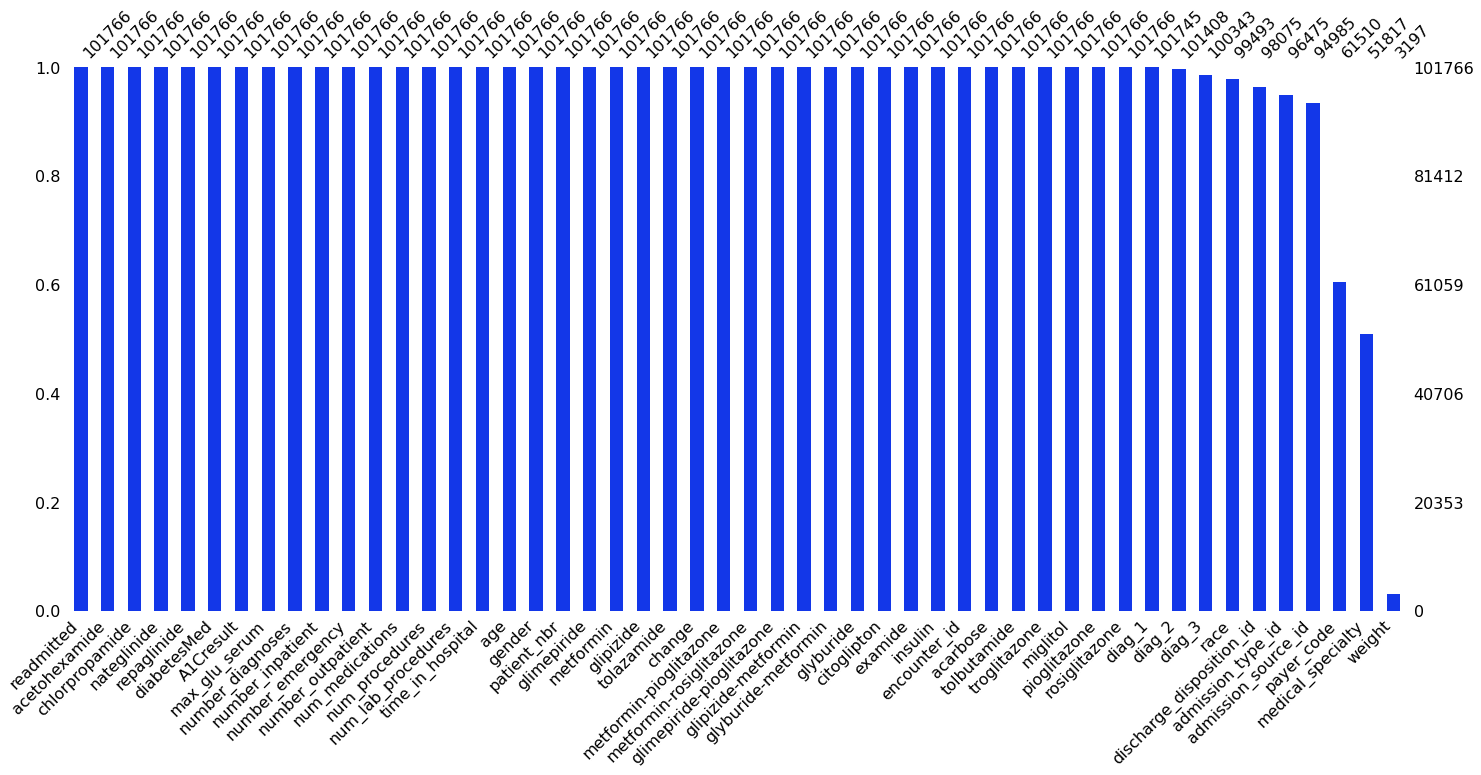

In [12]:
#Use the msno to show the missing values in the dataset
data = df.replace("?",np.nan)
msno.bar(data,sort='descending',color='#1337e8')
plt.show()

5. Understanding that we have some missing values in the dataset, we start working on Processing the dataset and removing, imputing and cleaning wrong features.

We use the **remove_wrong_columns()** method to remove columns with more than 2% missing value based on a set metrics

In [13]:
wc_df = data_obj.remove_wrong_columns(df)
wc_df

gender      age  time_in_hospital  num_lab_procedures  num_procedures  \
0       Female   [0-10)                 1                  41               0   
1       Female  [10-20)                 3                  59               0   
2       Female  [20-30)                 2                  11               5   
3         Male  [30-40)                 2                  44               1   
4         Male  [40-50)                 1                  51               0   
...        ...      ...               ...                 ...             ...   
101761    Male  [70-80)                 3                  51               0   
101762  Female  [80-90)                 5                  33               3   
101763    Male  [70-80)                 1                  53               0   
101764  Female  [80-90)                10                  45               2   
101765    Male  [70-80)                 6                  13               3   

        num_medications  number_outpatient  number_emergency  \
0                     1                  0                 0   
1                    18                  0                 0   
2                    13                  2                 0   
3                    16                  0                 0   
4                     8                  0                 0   
...                 ...                ...               ...   
101761               16                  0                 0   
101762               18                  0                 0   
101763                9                  1                 0   
101764               21                  0                 0   
101765                3                  0                 0   

        number_inpatient  diag_1  diag_2 diag_3  number_diagnoses  \
0                      0  250.83       ?      ?                 1   
1                      0     276  250.01    255                 9   
2                      1     648     250    V27                 6   
3                      0       8  250.43    403                 7   
4                      0     197     157    250                 5   
...                  ...     ...     ...    ...               ...   
101761                 0  250.13     291    458                 9   
101762                 1     560     276    787                 9   
101763                 0      38     590    296                13   
101764                 1     996     285    998                 9   
101765                 0     530     530    787                 9   

       max_glu_serum A1Cresult metformin repaglinide nateglinide  \
0               None      None        No          No          No   
1               None      None        No          No          No   
2               None      None        No          No          No   
3               None      None        No          No          No   
4               None      None        No          No          No   
...              ...       ...       ...         ...         ...   
101761          None        >8    Steady          No          No   
101762          None      None        No          No          No   
101763          None      None    Steady          No          No   
101764          None      None        No          No          No   
101765          None      None        No          No          No   

       chlorpropamide glimepiride acetohexamide glipizide glyburide  \
0                  No          No            No        No        No   
1                  No          No            No        No        No   
2                  No          No            No    Steady        No   
3                  No          No            No        No        No   
4                  No          No            No    Steady        No   
...               ...         ...           ...       ...       ...   
101761             No          No            No        No        No   
101762             No          No            No     

6. Cleaning based on entries in the dataset.<br>
**Here we use the data_cleaning() object**<br>
a. Replace the "?" with Nans <br>
b. Backward fill the Nans in the dataset

In [14]:
cleaned_df = data_obj.data_cleaning(wc_df)
cleaned_df

gender      age time_in_hospital num_lab_procedures num_procedures  \
0       Female   [0-10)                1                 41              0   
1       Female  [10-20)                3                 59              0   
2       Female  [20-30)                2                 11              5   
3         Male  [30-40)                2                 44              1   
4         Male  [40-50)                1                 51              0   
...        ...      ...              ...                ...            ...   
101761    Male  [70-80)                3                 51              0   
101762  Female  [80-90)                5                 33              3   
101763    Male  [70-80)                1                 53              0   
101764  Female  [80-90)               10                 45              2   
101765    Male  [70-80)                6                 13              3   

       num_medications number_outpatient number_emergency number_inpatient  \
0                    1                 0                0                0   
1                   18                 0                0                0   
2                   13                 2                0                1   
3                   16                 0                0                0   
4                    8                 0                0                0   
...                ...               ...              ...              ...   
101761              16                 0                0                0   
101762              18                 0                0                1   
101763               9                 1                0                0   
101764              21                 0                0                1   
101765               3                 0                0                0   

        diag_1  diag_2 diag_3 number_diagnoses max_glu_serum A1Cresult  \
0       250.83       1      1                1          None      None   
1          276  250.01    255                9          None      None   
2          648     250    V27                6          None      None   
3            8  250.43    403                7          None      None   
4          197     157    250                5          None      None   
...        ...     ...    ...              ...           ...       ...   
101761  250.13     291    458                9          None        >8   
101762     560     276    787                9          None      None   
101763      38     590    296               13          None      None   
101764     996     285    998                9          None      None   
101765     530     530    787                9          None      None   

       metformin repaglinide nateglinide chlorpropamide glimepiride  \
0             No          No          No             No          No   
1             No          No          No             No          No   
2             No          No          No             No          No   
3             No          No          No             No          No   
4             No          No          No             No          No   
...          ...         ...         ...            ...         ...   
101761    Steady          No          No             No          No   
101762        No          No          No             No          No   
101763    Steady          No          No             No          No   
101764        No          No          No             No          No   
101765        No          No          No             No          No   

       acetohexamide glipizide glyburide tolbutamide pioglitazone  \
0                 No        No        No          No           No   
1                 No        No        No          No           No   
2                 No    Steady        No          No           No   
3                 No        No        No          No           No   
4                 No    Steady        No       

7. Check the number of classes in the **Target Variable**

In [15]:
cleaned_df.readmitted.value_counts()

NO     54861
>30    35545
<30    11357
Name: readmitted, dtype: int64

Check the summary of the data again

In [16]:
#Check the dataset summary
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101763 entries, 0 to 101765
Data columns (total 39 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   gender                    101763 non-null  object
 1   age                       101763 non-null  object
 2   time_in_hospital          101763 non-null  object
 3   num_lab_procedures        101763 non-null  object
 4   num_procedures            101763 non-null  object
 5   num_medications           101763 non-null  object
 6   number_outpatient         101763 non-null  object
 7   number_emergency          101763 non-null  object
 8   number_inpatient          101763 non-null  object
 9   diag_1                    101763 non-null  object
 10  diag_2                    101763 non-null  object
 11  diag_3                    101763 non-null  object
 12  number_diagnoses          101763 non-null  object
 13  max_glu_serum             101763 non-null  object
 14  A1Cr

Check if the dataset for Nans 

In [17]:
data_obj.check_nan(cleaned_df)

column_name  percentage
0                     gender         0.0
1                        age         0.0
2           time_in_hospital         0.0
3         num_lab_procedures         0.0
4             num_procedures         0.0
5            num_medications         0.0
6          number_outpatient         0.0
7           number_emergency         0.0
8           number_inpatient         0.0
9                     diag_1         0.0
10                    diag_2         0.0
11                    diag_3         0.0
12          number_diagnoses         0.0
13             max_glu_serum         0.0
14                 A1Cresult         0.0
15                 metformin         0.0
16               repaglinide         0.0
17               nateglinide         0.0
18            chlorpropamide         0.0
19               glimepiride         0.0
20             acetohexamide         0.0
21                 glipizide         0.0
22                 glyburide         0.0
23               tolbutamide         0.0
24              pioglitazone         0.0
25             rosiglitazone         0.0
26                  acarbose         0.0
27                  miglitol         0.0
28              troglitazone         0.0
29                tolazamide         0.0
30                   insulin         0.0
31       glyburide-metformin         0.0
32       glipizide-metformin         0.0
33  glimepiride-pioglitazone         0.0
34   metformin-rosiglitazone         0.0
35    metformin-pioglitazone         0.0
36                    change         0.0
37               diabetesMed         0.0
38                readmitted         0.0

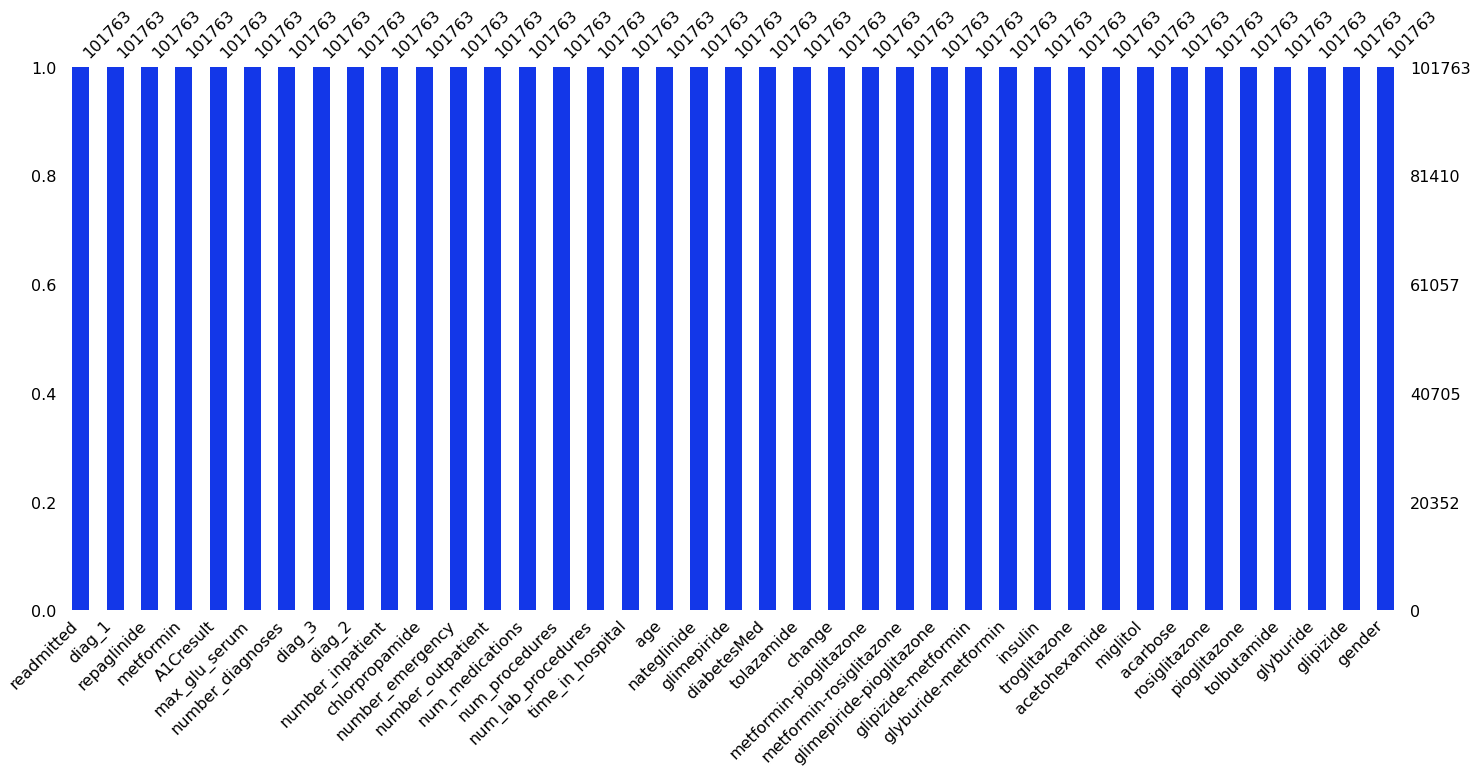

In [18]:
msno.bar(cleaned_df,sort='descending',color='#1337e8')
plt.show()

Get a quick summary of the dataset

In [19]:
df = cleaned_df
df.head()

gender      age time_in_hospital num_lab_procedures num_procedures  \
0  Female   [0-10)                1                 41              0   
1  Female  [10-20)                3                 59              0   
2  Female  [20-30)                2                 11              5   
3    Male  [30-40)                2                 44              1   
4    Male  [40-50)                1                 51              0   

  num_medications number_outpatient number_emergency number_inpatient  diag_1  \
0               1                 0                0                0  250.83   
1              18                 0                0                0     276   
2              13                 2                0                1     648   
3              16                 0                0                0       8   
4               8                 0                0                0     197   

   diag_2 diag_3 number_diagnoses max_glu_serum A1Cresult metformin  \
0       1      1                1          None      None        No   
1  250.01    255                9          None      None        No   
2     250    V27                6          None      None        No   
3  250.43    403                7          None      None        No   
4     157    250                5          None      None        No   

  repaglinide nateglinide chlorpropamide glimepiride acetohexamide glipizide  \
0          No          No             No          No            No        No   
1          No          No             No          No            No        No   
2          No          No             No          No            No    Steady   
3          No          No             No          No            No        No   
4          No          No             No          No            No    Steady   

  glyburide tolbutamide pioglitazone rosiglitazone acarbose miglitol  \
0        No          No           No            No       No       No   
1        No          No           No            No       No       No   
2        No          No           No            No       No       No   
3        No          No           No            No       No       No   
4        No          No           No            No       No       No   

  troglitazone tolazamide insulin glyburide-metformin glipizide-metformin  \
0           No         No      No                  No                  No   
1           No         No      Up                  No                  No   
2           No         No      No                  No                  No   
3           No         No      Up                  No                  No   
4           No         No  Steady                  No                  No   

  glimepiride-pioglitazone metformin-rosiglitazone metformin-pioglitazone  \
0                       No                      No                     No   
1                       No                      No                     No   
2                       No                      No                     No   
3                       No                      No                     No   
4                       No                      No                     No   

  change diabetesMed readmitted  
0     No          No         NO  
1     Ch         Yes        >30  
2     No         Yes         NO  
3     Ch         Yes         NO  
4     Ch         Yes         NO

In [20]:
#Check the entries in diag-1 - 3 features
df.diag_1

0         250.83
1            276
2            648
3              8
4            197
           ...  
101761    250.13
101762       560
101763        38
101764       996
101765       530
Name: diag_1, Length: 101763, dtype: object

8. Noticing that diag_1 - diag_3 has unclear entries we used the **transform_diagnosis method()** based on domain knowledge to transform the dataset into the appropriate entries.

In [21]:
#Transform the diag_1, diag_2 and diag_3 features
diag_df = data_obj.transform_diagnosis(df, ["diag_1","diag_2","diag_3"])
diag_df

gender      age time_in_hospital num_lab_procedures num_procedures  \
0       Female   [0-10)                1                 41              0   
1       Female  [10-20)                3                 59              0   
2       Female  [20-30)                2                 11              5   
3         Male  [30-40)                2                 44              1   
4         Male  [40-50)                1                 51              0   
...        ...      ...              ...                ...            ...   
101761    Male  [70-80)                3                 51              0   
101762  Female  [80-90)                5                 33              3   
101763    Male  [70-80)                1                 53              0   
101764  Female  [80-90)               10                 45              2   
101765    Male  [70-80)                6                 13              3   

       num_medications number_outpatient number_emergency number_inpatient  \
0                    1                 0                0                0   
1                   18                 0                0                0   
2                   13                 2                0                1   
3                   16                 0                0                0   
4                    8                 0                0                0   
...                ...               ...              ...              ...   
101761              16                 0                0                0   
101762              18                 0                0                1   
101763               9                 1                0                0   
101764              21                 0                0                1   
101765               3                 0                0                0   

           diag_1         diag_2       diag_3 number_diagnoses max_glu_serum  \
0        Diabetes          Other        Other                1          None   
1           Other       Diabetes        Other                9          None   
2           Other       Diabetes        Other                6          None   
3           Other       Diabetes  Circulatory                7          None   
4       Neoplasms      Neoplasms     Diabetes                5          None   
...           ...            ...          ...              ...           ...   
101761   Diabetes          Other  Circulatory                9          None   
101762  Digestive          Other    Digestive                9          None   
101763      Other  Genitourinary        Other               13          None   
101764     Injury          Other       Injury                9          None   
101765  Digestive      Digestive    Digestive                9          None   

       A1Cresult metformin repaglinide nateglinide chlorpropamide glimepiride  \
0           None        No          No          No             No          No   
1           None        No          No          No             No          No   
2           None        No          No          No             No          No   
3           None        No          No          No             No          No   
4           None        No          No          No             No          No   
...          ...       ...         ...         ...            ...         ...   
101761        >8    Steady          No          No             No          No   
101762      None        No          No          No             No          No   
101763      None    Steady          No          No             No          No   
101764      None        No          No          No             No          No   
101765      None        No          No          No             No          No   

       acetohexamide glipizide glyburide tolbutamide pioglitazone  \
0                 No        No        No          No           No   
1                 No        No        No          No          

In [22]:
diag_df["diag_1"].value_counts()

Circulatory        30438
Other              18184
Respiratory        14424
Digestive           9475
Diabetes            8760
Injury              6973
Genitourinary       5119
Musculoskeletal     4957
Neoplasms           3433
Name: diag_1, dtype: int64

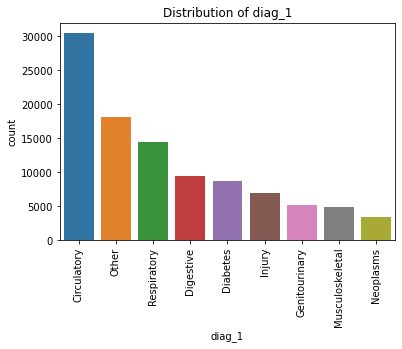

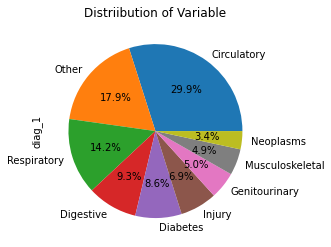

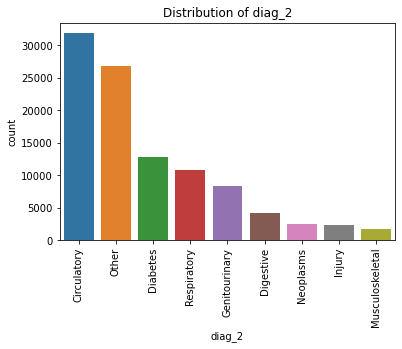

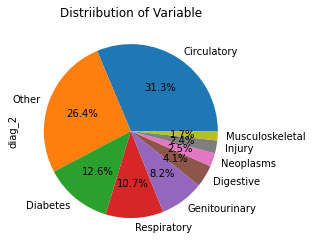

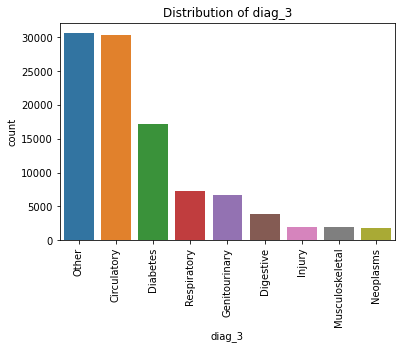

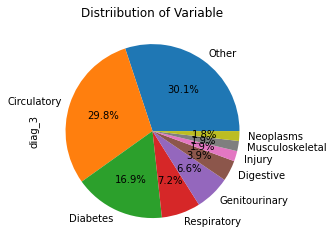

In [23]:

diag_cols = ["diag_1","diag_2","diag_3"]

for diag in diag_cols:
    data_obj.category_plots(diag_df,diag)


In [24]:
#describe the dataset
diag_df.describe()

gender      age  time_in_hospital  num_lab_procedures  num_procedures  \
count   101763   101763            101763              101763          101763   
unique       2       10                14                 118               7   
top     Female  [70-80)                 3                   1               0   
freq     54708    26066             17756                3208           46652   

        num_medications  number_outpatient  number_emergency  \
count            101763             101763            101763   
unique               75                 39                33   
top                  13                  0                 0   
freq               6086              85024             90380   

        number_inpatient       diag_1       diag_2  diag_3  number_diagnoses  \
count             101763       101763       101763  101763            101763   
unique                21            9            9       9                16   
top                    0  Circulatory  Circulatory   Other                 9   
freq               67627        30438        31897   30617             49473   

       max_glu_serum A1Cresult metformin repaglinide nateglinide  \
count         101763    101763    101763      101763      101763   
unique             4         4         4           4           4   
top             None      None        No          No          No   
freq           96417     84745     81776      100224      101060   

       chlorpropamide glimepiride acetohexamide glipizide glyburide  \
count          101763      101763        101763    101763    101763   
unique              4           4             2         4         4   
top                No          No            No        No        No   
freq           101677       96572        101762     89078     91113   

       tolbutamide pioglitazone rosiglitazone acarbose miglitol troglitazone  \
count       101763       101763        101763   101763   101763       101763   
unique           2            4             4        4        4            2   
top             No           No            No       No       No           No   
freq        101740        94436         95399   101455   101725       101760   

       tolazamide insulin glyburide-metformin glipizide-metformin  \
count      101763  101763              101763              101763   
unique          3       4                   4                   2   
top            No      No                  No                  No   
freq       101724   47380              101057              101750   

       glimepiride-pioglitazone metformin-rosiglitazone  \
count                    101763                  101763   
unique                        2                       2   
top                          No                      No   
freq                     101762                  101761   

       metformin-pioglitazone  change diabetesMed readmitted  
count                  101763  101763      101763     101763  
unique                      2       2           2          3  
top                        No      No         Yes         NO  
freq                   101762   54754       78361      54861

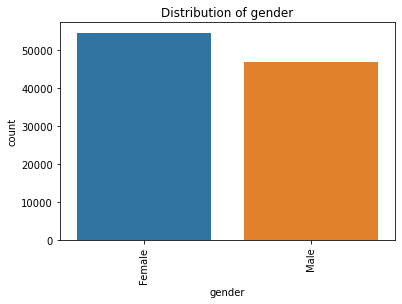

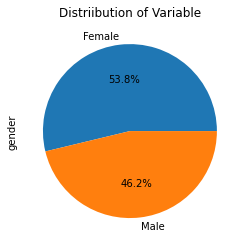

In [25]:
#Plot the gender category with the category_plot function
data_obj.category_plots(diag_df, "gender")

9. Using the **encoded_data** method, encode readmission, race etc features

In [26]:
#encode the data with encoded_data method
encoded_df = data_obj.encoded_data(diag_df)
encoded_df

gender      age  time_in_hospital  num_lab_procedures  num_procedures  \
0       Female   [0-10)                 1                  41               0   
1       Female  [10-20)                 3                  59               0   
2       Female  [20-30)                 2                  11               5   
3         Male  [30-40)                 2                  44               1   
4         Male  [40-50)                 1                  51               0   
...        ...      ...               ...                 ...             ...   
101761    Male  [70-80)                 3                  51               0   
101762  Female  [80-90)                 5                  33               3   
101763    Male  [70-80)                 1                  53               0   
101764  Female  [80-90)                10                  45               2   
101765    Male  [70-80)                 6                  13               3   

        num_medications  number_outpatient  number_emergency  \
0                     1                  0                 0   
1                    18                  0                 0   
2                    13                  2                 0   
3                    16                  0                 0   
4                     8                  0                 0   
...                 ...                ...               ...   
101761               16                  0                 0   
101762               18                  0                 0   
101763                9                  1                 0   
101764               21                  0                 0   
101765                3                  0                 0   

        number_inpatient     diag_1         diag_2       diag_3  \
0                      0   Diabetes          Other        Other   
1                      0      Other       Diabetes        Other   
2                      1      Other       Diabetes        Other   
3                      0      Other       Diabetes  Circulatory   
4                      0  Neoplasms      Neoplasms     Diabetes   
...                  ...        ...            ...          ...   
101761                 0   Diabetes          Other  Circulatory   
101762                 1  Digestive          Other    Digestive   
101763                 0      Other  Genitourinary        Other   
101764                 1     Injury          Other       Injury   
101765                 0  Digestive      Digestive    Digestive   

        number_diagnoses  max_glu_serum  A1Cresult  metformin  repaglinide  \
0                      1              0          0          0            0   
1                      9              0          0          0            0   
2                      6              0          0          0            0   
3                      7              0          0          0            0   
4                      5              0          0          0            0   
...                  ...            ...        ...        ...          ...   
101761                 9              0          2          1            0   
101762                 9              0          0          0            0   
101763                13              0          0          1            0   
101764                 9              0          0          0            0   
101765                 9              0          0          0            0   

        nateglinide  chlorpropamide  glimepiride  acetohexamide  glipizide  \
0                 0               0            0              0          0   
1                 0               0            0              0          0   
2                 0               0            0              0          1   
3                 0               0            0              0          0   
4                 0               0            0              0          1   
...             ...             ...          ...        

In [27]:
#Check the summary of the data after encoding it
encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101763 entries, 0 to 101765
Data columns (total 39 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   gender                    101763 non-null  object
 1   age                       101763 non-null  object
 2   time_in_hospital          101763 non-null  int64 
 3   num_lab_procedures        101763 non-null  int64 
 4   num_procedures            101763 non-null  int64 
 5   num_medications           101763 non-null  int64 
 6   number_outpatient         101763 non-null  int64 
 7   number_emergency          101763 non-null  int64 
 8   number_inpatient          101763 non-null  int64 
 9   diag_1                    101763 non-null  object
 10  diag_2                    101763 non-null  object
 11  diag_3                    101763 non-null  object
 12  number_diagnoses          101763 non-null  int64 
 13  max_glu_serum             101763 non-null  int64 
 14  A1Cr

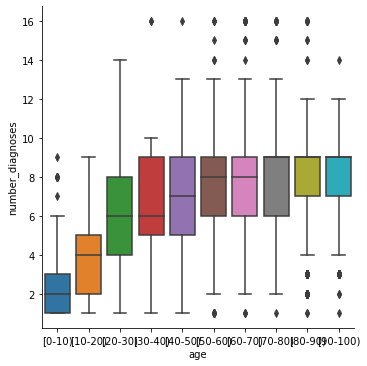

In [28]:
#Check the outliers in different age
sns.catplot(x="age", y="number_diagnoses", kind="box", data=encoded_df)

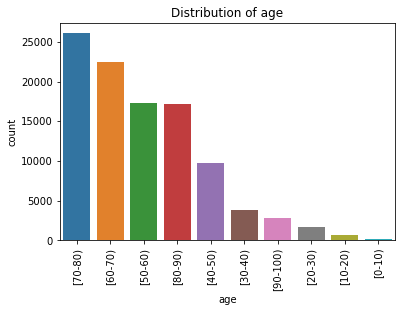

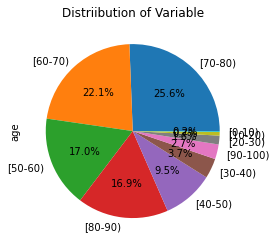

In [29]:
#plot the age categories in the dataset
data_obj.category_plots(encoded_df, "age")

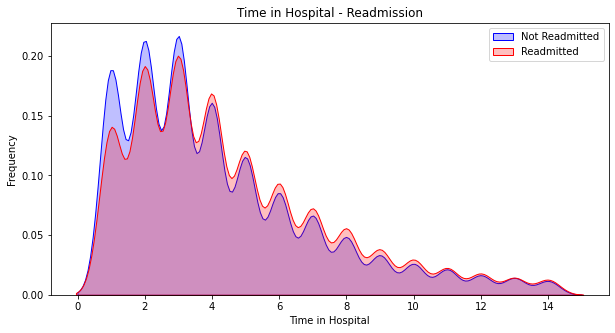

In [30]:
data_obj.area_plots(encoded_df, encoded_df.readmitted == 0, encoded_df.readmitted == 1, "time_in_hospital", "Time in Hospital")

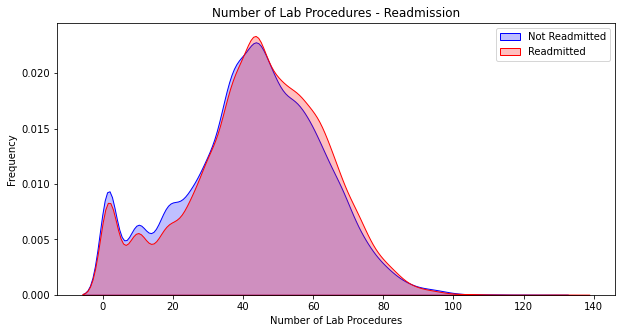

In [31]:
data_obj.area_plots(encoded_df, encoded_df.readmitted == 0, encoded_df.readmitted == 1, "num_lab_procedures",\
                    "Number of Lab Procedures")

In [32]:
#check the unique entries in the max_glu_serum features
encoded_df.max_glu_serum.value_counts()

0    96417
2     2749
1     2597
Name: max_glu_serum, dtype: int64

10. Make a copy of the dataset for the **Machine Learning** task

In [33]:
#Create a copy of the Dataset
diabetes_df = encoded_df.copy()
diabetes_df

gender      age  time_in_hospital  num_lab_procedures  num_procedures  \
0       Female   [0-10)                 1                  41               0   
1       Female  [10-20)                 3                  59               0   
2       Female  [20-30)                 2                  11               5   
3         Male  [30-40)                 2                  44               1   
4         Male  [40-50)                 1                  51               0   
...        ...      ...               ...                 ...             ...   
101761    Male  [70-80)                 3                  51               0   
101762  Female  [80-90)                 5                  33               3   
101763    Male  [70-80)                 1                  53               0   
101764  Female  [80-90)                10                  45               2   
101765    Male  [70-80)                 6                  13               3   

        num_medications  number_outpatient  number_emergency  \
0                     1                  0                 0   
1                    18                  0                 0   
2                    13                  2                 0   
3                    16                  0                 0   
4                     8                  0                 0   
...                 ...                ...               ...   
101761               16                  0                 0   
101762               18                  0                 0   
101763                9                  1                 0   
101764               21                  0                 0   
101765                3                  0                 0   

        number_inpatient     diag_1         diag_2       diag_3  \
0                      0   Diabetes          Other        Other   
1                      0      Other       Diabetes        Other   
2                      1      Other       Diabetes        Other   
3                      0      Other       Diabetes  Circulatory   
4                      0  Neoplasms      Neoplasms     Diabetes   
...                  ...        ...            ...          ...   
101761                 0   Diabetes          Other  Circulatory   
101762                 1  Digestive          Other    Digestive   
101763                 0      Other  Genitourinary        Other   
101764                 1     Injury          Other       Injury   
101765                 0  Digestive      Digestive    Digestive   

        number_diagnoses  max_glu_serum  A1Cresult  metformin  repaglinide  \
0                      1              0          0          0            0   
1                      9              0          0          0            0   
2                      6              0          0          0            0   
3                      7              0          0          0            0   
4                      5              0          0          0            0   
...                  ...            ...        ...        ...          ...   
101761                 9              0          2          1            0   
101762                 9              0          0          0            0   
101763                13              0          0          1            0   
101764                 9              0          0          0            0   
101765                 9              0          0          0            0   

        nateglinide  chlorpropamide  glimepiride  acetohexamide  glipizide  \
0                 0               0            0              0          0   
1                 0               0            0              0          0   
2                 0               0            0              0          1   
3                 0               0            0              0          0   
4                 0               0            0              0          1   
...             ...             ...          ...        

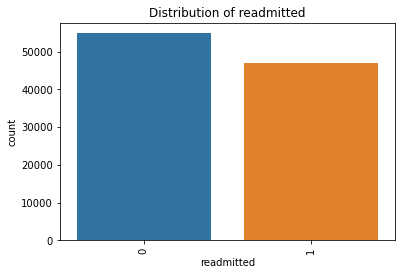

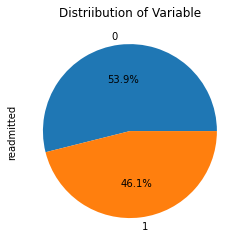

In [34]:
#Plot the target variabe
data_obj.category_plots(diabetes_df, "readmitted")

11. Separate the target class asside from other feature together

In [35]:
X = diabetes_df.drop(columns="readmitted", axis=1)
Y = diabetes_df.readmitted

In [36]:
Y

0         0
1         1
2         0
3         0
4         0
         ..
101761    1
101762    0
101763    0
101764    0
101765    0
Name: readmitted, Length: 101763, dtype: int64

In [37]:
X

gender      age  time_in_hospital  num_lab_procedures  num_procedures  \
0       Female   [0-10)                 1                  41               0   
1       Female  [10-20)                 3                  59               0   
2       Female  [20-30)                 2                  11               5   
3         Male  [30-40)                 2                  44               1   
4         Male  [40-50)                 1                  51               0   
...        ...      ...               ...                 ...             ...   
101761    Male  [70-80)                 3                  51               0   
101762  Female  [80-90)                 5                  33               3   
101763    Male  [70-80)                 1                  53               0   
101764  Female  [80-90)                10                  45               2   
101765    Male  [70-80)                 6                  13               3   

        num_medications  number_outpatient  number_emergency  \
0                     1                  0                 0   
1                    18                  0                 0   
2                    13                  2                 0   
3                    16                  0                 0   
4                     8                  0                 0   
...                 ...                ...               ...   
101761               16                  0                 0   
101762               18                  0                 0   
101763                9                  1                 0   
101764               21                  0                 0   
101765                3                  0                 0   

        number_inpatient     diag_1         diag_2       diag_3  \
0                      0   Diabetes          Other        Other   
1                      0      Other       Diabetes        Other   
2                      1      Other       Diabetes        Other   
3                      0      Other       Diabetes  Circulatory   
4                      0  Neoplasms      Neoplasms     Diabetes   
...                  ...        ...            ...          ...   
101761                 0   Diabetes          Other  Circulatory   
101762                 1  Digestive          Other    Digestive   
101763                 0      Other  Genitourinary        Other   
101764                 1     Injury          Other       Injury   
101765                 0  Digestive      Digestive    Digestive   

        number_diagnoses  max_glu_serum  A1Cresult  metformin  repaglinide  \
0                      1              0          0          0            0   
1                      9              0          0          0            0   
2                      6              0          0          0            0   
3                      7              0          0          0            0   
4                      5              0          0          0            0   
...                  ...            ...        ...        ...          ...   
101761                 9              0          2          1            0   
101762                 9              0          0          0            0   
101763                13              0          0          1            0   
101764                 9              0          0          0            0   
101765                 9              0          0          0            0   

        nateglinide  chlorpropamide  glimepiride  acetohexamide  glipizide  \
0                 0               0            0              0          0   
1                 0               0            0              0          0   
2                 0               0            0              0          1   
3                 0               0            0              0          0   
4                 0               0            0              0          1   
...             ...             ...          ...        

11. Split the data into train and test sets using the **sklearn train_test_split()** method

In [38]:
#Split the dataset into two, 25% for testing and the other 75% for trainng
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 42)

In [39]:
X_train["age"].value_counts()

[70-80)     19696
[60-70)     16773
[50-60)     12906
[80-90)     12820
[40-50)      7290
[30-40)      2836
[90-100)     2104
[20-30)      1253
[10-20)       525
[0-10)        119
Name: age, dtype: int64

We encode the age feature into an ordinar (ordered) data type

In [40]:
categories_train = pd.Categorical(X_train["age"], categories=['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)','[60-70)', '[70-80)',\
                                                        '[80-90)', '[90-100)'], ordered=True)
categories_test = pd.Categorical(X_test["age"], categories=['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)','[60-70)', '[70-80)',\
                                                        '[80-90)', '[90-100)'], ordered=True)
categories_train

['[70-80)', '[80-90)', '[60-70)', '[40-50)', '[60-70)', ..., '[70-80)', '[60-70)', '[90-100)', '[60-70)', '[40-50)']
Length: 76322
Categories (10, object): ['[0-10)' < '[10-20)' < '[20-30)' < '[30-40)' ... '[60-70)' < '[70-80)' < '[80-90)' < '[90-100)']

In [41]:
X_train.loc[:, 'age'], unique = pd.factorize(categories_train, sort=True)
X_test.loc[:, 'age'], unique = pd.factorize(categories_test, sort=True)


C:\Users\PC\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [42]:
#get the values o the encoded age variables in the train set
X_train.age.value_counts()

7    19696
6    16773
5    12906
8    12820
4     7290
3     2836
9     2104
2     1253
1      525
0      119
Name: age, dtype: int64

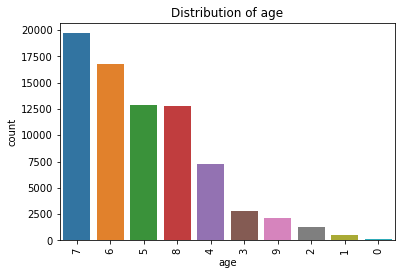

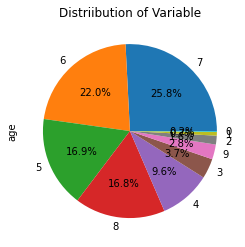

In [43]:
#Plot the age feature with category_plot method
data_obj.category_plots(X_train, "age")

In [44]:
#Check the distict age values in the test set
X_test.age.value_counts()

7    6370
6    5709
8    4377
5    4350
4    2395
3     939
9     689
2     404
1     166
0      42
Name: age, dtype: int64

Use Binary encoder methos of sklearn to encode Change, DiabetesMed and Gender features

In [45]:
diag_list= ["diag_1","diag_2","diag_3"]
for col in diag_list:
    X_train[col] = LabelEncoder().fit_transform(X_train[col])
    X_test[col] = LabelEncoder().fit_transform(X_test[col]) 
binary = ['change', 'diabetesMed', 'gender']
from category_encoders import BinaryEncoder
binary_enc = BinaryEncoder(cols=binary)
binary_enc.fit_transform(X_train)
X_train = binary_enc.fit_transform(X_train)
X_test = binary_enc.transform(X_test)

<ipython-input-45-3cd8fd616bfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = LabelEncoder().fit_transform(X_train[col])
<ipython-input-45-3cd8fd616bfb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = LabelEncoder().fit_transform(X_test[col])
C:\Users\PC\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\U

In [46]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76322 entries, 16207 to 15795
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   gender_0                  76322 non-null  int64
 1   gender_1                  76322 non-null  int64
 2   age                       76322 non-null  int64
 3   time_in_hospital          76322 non-null  int64
 4   num_lab_procedures        76322 non-null  int64
 5   num_procedures            76322 non-null  int64
 6   num_medications           76322 non-null  int64
 7   number_outpatient         76322 non-null  int64
 8   number_emergency          76322 non-null  int64
 9   number_inpatient          76322 non-null  int64
 10  diag_1                    76322 non-null  int32
 11  diag_2                    76322 non-null  int32
 12  diag_3                    76322 non-null  int32
 13  number_diagnoses          76322 non-null  int64
 14  max_glu_serum             76322 no

In [47]:
X_train.diag_1.value_counts()

0    22848
7    13659
8    10827
2     7014
1     6621
4     5239
3     3837
5     3703
6     2574
Name: diag_1, dtype: int64

In [48]:
X_train

gender_0  gender_1  age  time_in_hospital  num_lab_procedures  \
16207          0         1    7                11                  45   
101518         0         1    8                 2                   5   
88540          0         1    6                 9                  51   
19948          0         1    4                 1                  68   
47365          0         1    6                 2                  52   
...          ...       ...  ...               ...                 ...   
6265           0         1    7                 2                  35   
54887          1         0    6                 4                  42   
76822          1         0    9                 4                  30   
860            1         0    6                12                  77   
15795          1         0    4                 1                   2   

        num_procedures  num_medications  number_outpatient  number_emergency  \
16207                3               25                  0                 0   
101518               0               12                  0                 0   
88540                1               31                  0                 0   
19948                0               11                  0                 0   
47365                0                9                  0                 0   
...                ...              ...                ...               ...   
6265                 0               12                  0                 0   
54887                2               18                  0                 0   
76822                1               16                  0                 0   
860                  2               21                  0                 0   
15795                5               17                  0                 0   

        number_inpatient  diag_1  diag_2  diag_3  number_diagnoses  \
16207                  0       1       0       7                 9   
101518                 0       0       0       0                 9   
88540                  1       8       7       0                 7   
19948                  0       8       7       7                 9   
47365                  2       7       3       0                 8   
...                  ...     ...     ...     ...               ...   
6265                   0       8       0       0                 9   
54887                  0       8       8       0                 9   
76822                  2       6       0       0                 6   
860                    0       8       8       3                 9   
15795                  0       0       0       7                 7   

        max_glu_serum  A1Cresult  metformin  repaglinide  nateglinide  \
16207               0          0          0            0            0   
101518              0          0          1            0            0   
88540               0          0          0            0            0   
19948               0          2          0            0            0   
47365               0          2          0            0            0   
...               ...        ...        ...          ...          ...   
6265                0          0          0            0            0   
54887               0          0          1            0            0   
76822               0          0          0            0            0   
860                 0          0          0            0            0   
15795               0          0          0            0            0   

        chlorpropamide  glimepiride  acetohexamide  glipizide  glyburide  \
16207                0            0              0          0          0   
101518               0            0              0          0          1   
88540                0            0              0          0          0   
19948                0            0              0          0          0   
47365                0            0              0          0          0

In [49]:
X_test

gender_0  gender_1  age  time_in_hospital  num_lab_procedures  \
35957         1         0    7                 4                  66   
60928         1         0    3                 2                  48   
79920         1         0    6                 4                  21   
50079         1         0    3                 5                  38   
44081         0         1    5                 1                   6   
...         ...       ...  ...               ...                 ...   
2145          1         0    5                 3                  19   
56353         1         0    7                 3                  49   
11754         1         0    7                 8                  77   
37790         0         1    3                 1                  26   
31704         1         0    7                 7                  44   

       num_procedures  num_medications  number_outpatient  number_emergency  \
35957               3               18                  0                 0   
60928               0               15                  4                 0   
79920               3               23                  1                 0   
50079               0                5                  0                 0   
44081               0                6                  0                 0   
...               ...              ...                ...               ...   
2145                1               19                  1                 0   
56353               6               23                  0                 0   
11754               6               30                  0                 0   
37790               0                9                  0                 0   
31704               2               15                  0                 0   

       number_inpatient  diag_1  diag_2  diag_3  number_diagnoses  \
35957                 1       8       7       8                 9   
60928                 0       7       3       3                 7   
79920                 2       5       5       5                 7   
50079                 0       3       1       7                 2   
44081                 0       0       1       0                 6   
...                 ...     ...     ...     ...               ...   
2145                  2       1       4       7                 6   
56353                 0       0       0       0                 9   
11754                 0       0       3       0                 8   
37790                 0       8       0       1                 7   
31704                 0       5       5       7                 5   

       max_glu_serum  A1Cresult  metformin  repaglinide  nateglinide  \
35957              0          0          1            0            0   
60928              0          0          0            0            0   
79920              0          0          1            0            0   
50079              0          2          1            0            0   
44081              0          0          0            0            0   
...              ...        ...        ...          ...          ...   
2145               0          0          0            0            0   
56353              0          0          0            0            0   
11754              0          0          0            0            0   
37790              0          2          0            0            0   
31704              0          0          0            0            0   

       chlorpropamide  glimepiride  acetohexamide  glipizide  glyburide  \
35957               0            0              0          0          0   
60928               0            0              0          0          0   
79920               0            0              0          0          0   
50079               0            0              0          0          0   
44081               0            0              0          0          0   
...               ...          ...            ...

Check the number of entries of the target class in the train set

In [50]:
y_train.value_counts()

0    41172
1    35150
Name: readmitted, dtype: int64

12. Resample the dataset to have equal representation of the classes. This is done to avoid bias in the training data

In [51]:
downsampled = data_obj.resample(X_train, y_train)

In [52]:
downsampled

gender_0  gender_1  age  time_in_hospital  num_lab_procedures  \
42321         0         1    6                10                   5   
33337         0         1    5                 7                  81   
29181         0         1    4                 5                  36   
91961         0         1    4                 1                  30   
63805         0         1    4                 3                  15   
...         ...       ...  ...               ...                 ...   
37195         0         1    3                 2                  25   
82388         0         1    7                 4                  63   
6265          0         1    7                 2                  35   
76822         1         0    9                 4                  30   
860           1         0    6                12                  77   

       num_procedures  num_medications  number_outpatient  number_emergency  \
42321               3               10                  0                 0   
33337               3               19                  0                 0   
29181               1               11                  0                 0   
91961               2                7                  0                 0   
63805               1                8                  1                 0   
...               ...              ...                ...               ...   
37195               0                5                  0                 1   
82388               0               19                  3                 1   
6265                0               12                  0                 0   
76822               1               16                  0                 0   
860                 2               21                  0                 0   

       number_inpatient  diag_1  diag_2  diag_3  number_diagnoses  \
42321                 0       1       0       7                 9   
33337                 2       3       1       7                 5   
29181                 0       0       7       0                 7   
91961                 0       5       1       7                 3   
63805                 0       4       7       7                 6   
...                 ...     ...     ...     ...               ...   
37195                 0       1       7       7                 3   
82388                 0       4       3       0                 9   
6265                  0       8       0       0                 9   
76822                 2       6       0       0                 6   
860                   0       8       8       3                 9   

       max_glu_serum  A1Cresult  metformin  repaglinide  nateglinide  \
42321              0          0          0            0            0   
33337              0          0          0            0            0   
29181              0          2          0            0            0   
91961              0          0          1            0            0   
63805              0          0          0            0            0   
...              ...        ...        ...          ...          ...   
37195              0          0          0            0            0   
82388              0          2          0            0            0   
6265               0          0          0            0            0   
76822              0          0          0            0            0   
860                0          0          0            0            0   

       chlorpropamide  glimepiride  acetohexamide  glipizide  glyburide  \
42321               0            0              0          0          0   
33337               0            0              0          0          0   
29181               0            0              0          0          0   
91961               0            0              0          0          0   
63805               0            0              0          1          0   
...               ...          ...            ...

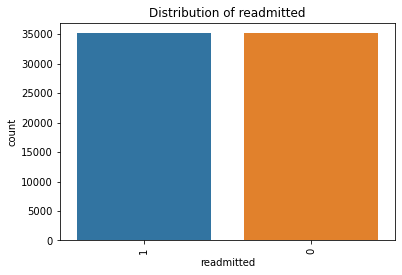

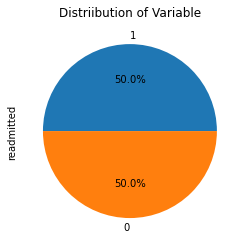

In [53]:
data_obj.category_plots(downsampled, "readmitted")

In [54]:
#Get the train dataset seperated into targer and features
y_train = downsampled.readmitted
X_train = downsampled.drop('readmitted', axis=1)

Use the Min Max Method to Scale the dataset

In [55]:

scaler = MinMaxScaler()
# build the scaler model
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
# fit using the train set

# transform the test test

X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [56]:
y_train

42321    0
33337    0
29181    0
91961    0
63805    0
        ..
37195    1
82388    1
6265     1
76822    1
860      1
Name: readmitted, Length: 70300, dtype: int64

Split the data into training and test sets

In [57]:
#Split the d 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)


In [58]:
X_train

gender_0  gender_1       age  time_in_hospital  num_lab_procedures  \
48363       1.0       0.0  0.555556          0.076923            0.328244   
50087       0.0       1.0  0.888889          0.615385            0.595420   
34811       0.0       1.0  0.555556          0.000000            0.374046   
16933       1.0       0.0  0.888889          0.153846            0.374046   
68529       0.0       1.0  0.555556          0.000000            0.320611   
...         ...       ...       ...               ...                 ...   
37194       0.0       1.0  1.000000          0.000000            0.312977   
6265        1.0       0.0  0.777778          0.000000            0.320611   
54886       1.0       0.0  0.555556          0.307692            0.374046   
860         1.0       0.0  0.666667          0.076923            0.297710   
15795       0.0       1.0  0.888889          0.230769            0.419847   

       num_procedures  num_medications  number_outpatient  number_emergency  \
48363        0.000000           0.1750            0.00000          0.000000   
50087        0.000000           0.3375            0.00000          0.000000   
34811        0.666667           0.0875            0.00000          0.000000   
16933        0.166667           0.1125            0.00000          0.000000   
68529        0.000000           0.2250            0.00000          0.000000   
...               ...              ...                ...               ...   
37194        0.000000           0.1500            0.02381          0.000000   
6265         0.000000           0.1250            0.00000          0.000000   
54886        0.333333           0.2125            0.00000          0.013158   
860          0.000000           0.1125            0.00000          0.000000   
15795        0.000000           0.1250            0.00000          0.000000   

       number_inpatient  diag_1  diag_2  diag_3  number_diagnoses  \
48363          0.000000   0.875   0.125   0.625          0.266667   
50087          0.000000   1.000   1.000   0.875          0.533333   
34811          0.000000   0.000   0.000   0.125          0.266667   
16933          0.000000   1.000   0.875   0.000          0.533333   
68529          0.052632   0.000   0.000   0.250          0.466667   
...                 ...     ...     ...     ...               ...   
37194          0.000000   1.000   1.000   0.125          0.133333   
6265           0.000000   0.000   0.000   0.125          0.266667   
54886          0.000000   0.375   0.000   0.125          0.533333   
860            0.000000   1.000   1.000   0.000          0.466667   
15795          0.000000   1.000   0.000   0.000          0.466667   

       max_glu_serum  A1Cresult  metformin  repaglinide  nateglinide  \
48363            0.0        0.0        0.0          0.0          0.0   
50087            0.0        0.0        1.0          0.0          0.0   
34811            0.0        0.0        0.0          0.0          0.0   
16933            0.0        0.0        1.0          0.0          0.0   
68529            0.0        0.0        0.0          0.0          0.0   
...              ...        ...        ...          ...          ...   
37194            0.0        0.0        0.0          0.0          0.0   
6265             0.0        0.0        0.0          0.0          0.0   
54886            0.0        0.0        1.0          0.0          0.0   
860              0.0        0.0        0.0          0.0          0.0   
15795            0.0        0.0        1.0          0.0          0.0   

       chlorpropamide  glimepiride  acetohexamide  glipizide  glyburide  \
48363             0.0          0.0            0.0        0.0        0.0   
50087             0.0          0.0            0.0        1.0        0.0   
34811             0.0          0.0            0.0        0.0        0.0   
16933             0.0          0.0            0.0        0.0        0.0   
68529             0.0          0.0            0.0        0.0    

In [59]:
X_val

gender_0  gender_1       age  time_in_hospital  num_lab_procedures  \
39980       1.0       0.0  0.666667          0.615385            0.389313   
22048       1.0       0.0  0.888889          0.153846            0.259542   
8051        0.0       1.0  0.333333          0.153846            0.274809   
46302       0.0       1.0  0.777778          0.153846            0.435115   
3186        1.0       0.0  0.888889          0.153846            0.366412   
...         ...       ...       ...               ...                 ...   
50531       0.0       1.0  0.444444          1.000000            0.427481   
18591       0.0       1.0  0.888889          0.230769            0.442748   
22249       0.0       1.0  0.666667          0.000000            0.427481   
40107       0.0       1.0  0.777778          0.615385            0.488550   
22215       0.0       1.0  0.444444          0.000000            0.137405   

       num_procedures  num_medications  number_outpatient  number_emergency  \
39980        0.500000           0.3125            0.00000          0.000000   
22048        0.000000           0.0750            0.00000          0.000000   
8051         0.000000           0.2250            0.02381          0.000000   
46302        0.000000           0.1500            0.02381          0.039474   
3186         0.166667           0.0875            0.02381          0.000000   
...               ...              ...                ...               ...   
50531        1.000000           0.3000            0.00000          0.000000   
18591        0.000000           0.0625            0.00000          0.000000   
22249        0.000000           0.1750            0.02381          0.000000   
40107        0.833333           0.2875            0.00000          0.000000   
22215        0.000000           0.0625            0.00000          0.000000   

       number_inpatient  diag_1  diag_2  diag_3  number_diagnoses  \
39980          0.000000   0.125   0.000   0.875          0.533333   
22048          0.052632   0.000   0.000   0.000          0.266667   
8051           0.000000   1.000   0.000   0.125          0.333333   
46302          0.157895   0.000   0.875   0.000          0.466667   
3186           0.000000   0.875   0.000   0.875          0.466667   
...                 ...     ...     ...     ...               ...   
50531          0.000000   0.375   0.500   0.375          0.400000   
18591          0.000000   0.875   0.125   0.875          0.533333   
22249          0.105263   1.000   0.875   0.875          0.400000   
40107          0.000000   0.500   0.500   0.000          0.333333   
22215          0.000000   1.000   0.875   0.125          0.333333   

       max_glu_serum  A1Cresult  metformin  repaglinide  nateglinide  \
39980            0.0        0.0        0.0          0.0          0.0   
22048            0.0        0.0        0.0          1.0          0.0   
8051             0.0        0.0        1.0          0.0          0.0   
46302            0.0        0.0        1.0          0.0          0.0   
3186             0.0        0.0        0.0          0.0          0.0   
...              ...        ...        ...          ...          ...   
50531            0.0        0.0        0.0          0.0          0.0   
18591            0.0        0.0        1.0          0.0          0.0   
22249            0.0        0.0        0.0          0.0          0.0   
40107            0.0        0.0        0.0          0.0          0.0   
22215            0.5        0.0        0.0          0.0          0.0   

       chlorpropamide  glimepiride  acetohexamide  glipizide  glyburide  \
39980             0.0          0.0            0.0        0.0        0.0   
22048             0.0          0.0            0.0        0.0        0.0   
8051              0.0          0.0            0.0        1.0        0.0   
46302             0.0          0.0            0.0        0.0        0.0   
3186              0.0          0.0            0.0        0.0    

In [60]:
#Fix The threshhold for 0.5
thresh = 0.5


    ***Baseline Model***
In this Project we applied different tree methods. <br>
We used the Decision Tree classifier and differen ensemble method because the data has many categorical features. <br>
1. We applied Random Forest as a bagging ensemble method
2. We applied Xgb, ada and catbost as boosting algorithms
3. We used the stacking ensemble method tocombine all the methods together to improve the base model before tuning the parameters. 

1. Decision Tree

In [61]:
#set the decision tree classifier with max depth of 4 and random state 42 as the base model. 
decision_model = DecisionTreeClassifier(max_depth = 4, random_state=42)
#Fit the model with the train dataset
decision_model.fit(X_train, y_train)
y_train_dc_preds = decision_model.predict_proba(X_train)[:,1]
y_val_dc_preds = decision_model.predict_proba(X_val)[:,1]

Use the **model_report() method** to print the performance metrics for the base decision tree model

In [62]:
print("Decision Tree")
print('Training:')
#Get the performance metrics for the training data
dc_train_auc, dc_train_accuracy, dc_train_recall, dc_train_precision,dc_train_fscore, dc_train_specificity \
=data_obj.model_report(y_train, y_train_dc_preds, thresh)
print('Validation:')
#Get the performance metrics for the validation data
dc_val_auc, dc_val_accuracy, dc_val_recall, dc_val_precision,dc_val_fscore, dc_val_specificity = \
data_obj.model_report(y_val, y_val_dc_preds, thresh)

Decision Tree
Training:
AUC:0.645
accuracy:0.610
recall:0.541
precision:0.629
fscore:0.581
specificity:0.681
 
Validation:
AUC:0.647
accuracy:0.613
recall:0.544
precision:0.629
fscore:0.584
specificity:0.681
 


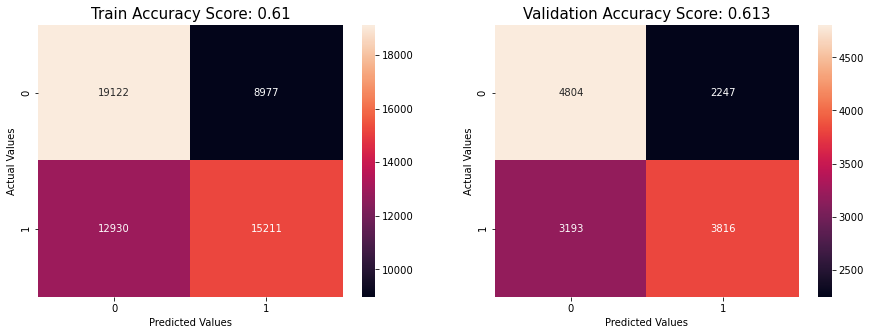

In [63]:
#Plot the heatmap for the model
data_obj.confusion_mat(decision_model, X_train, X_val, y_train, y_val)

2. Random Forest Bagging Ensemble Model

In [64]:
#set the decision tree classifier with n_jobs of -1, n_estimator of 100 and random state 42 as the base model.
random_forest_model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=100, max_depth=3)
random_forest_model.fit(X_train, y_train) 

RandomForestClassifier(max_depth=3, n_jobs=-1, random_state=42)

In [65]:
y_train_preds = random_forest_model.predict_proba(X_train)[:,1]
y_val_preds = random_forest_model.predict_proba(X_val)[:,1]

print("Random Forest")
print('Training:')
rf_train_auc, rf_train_accuracy, rf_train_recall, rf_train_precision,rf_train_fscore, rf_train_specificity \
=data_obj.model_report(y_train,y_train_preds, thresh)
print('Validation:')
rf_val_auc, rf_val_accuracy, rf_val_recall, rf_val_precision,rf_val_fscore, rf_val_specificity = \
data_obj.model_report(y_val,y_val_preds, thresh)

Random Forest
Training:
AUC:0.654
accuracy:0.611
recall:0.522
precision:0.636
fscore:0.574
specificity:0.700
 
Validation:
AUC:0.657
accuracy:0.615
recall:0.533
precision:0.637
fscore:0.580
specificity:0.698
 


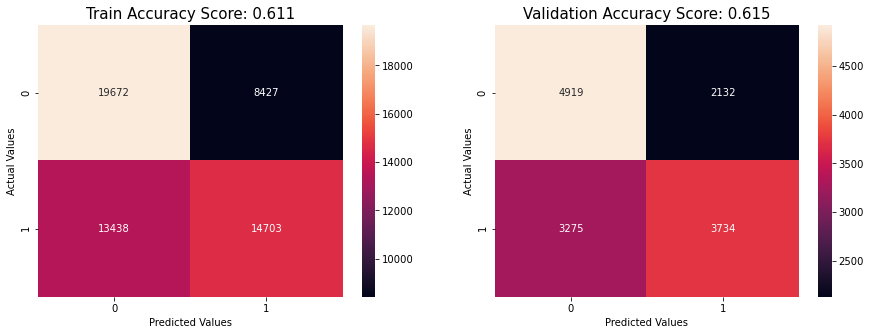

In [66]:
data_obj.confusion_mat(random_forest_model, X_train, X_val, y_train, y_val)

3. XGB Classifier

In [67]:
#set the XGB classifier with n_jobs of -1, and random state 42 as the base model.
xgb_model = XGBClassifier(random_state=42, n_jobs=-1,max_depth=3)
xgb_model.fit(X_train, y_train)

C:\Users\PC\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:27:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [68]:
y_train_preds = xgb_model.predict_proba(X_train)[:,1]
y_val_preds = xgb_model.predict_proba(X_val)[:,1]

print("XGBOOST")
y_train_preds = xgb_model.predict_proba(X_train)[:,1]
y_val_preds = xgb_model.predict_proba(X_val)[:,1]

print("Gradient Boosing")
print('Training:')
xgb_train_auc, xgb_train_accuracy, xgb_train_recall, xgb_train_precision, xgb_train_fscore, xgb_train_specificity = data_obj.model_report(y_train,y_train_preds, thresh)
print('Validation:')
xgb_val_auc, xgb_val_accuracy, xgb_val_recall, xgb_val_precision,xgb_val_fscore, xgb_val_specificity = data_obj.model_report(y_val,y_val_preds, thresh)


XGBOOST
Gradient Boosing
Training:
AUC:0.689
accuracy:0.634
recall:0.594
precision:0.646
fscore:0.619
specificity:0.675
 
Validation:
AUC:0.674
accuracy:0.620
recall:0.585
precision:0.628
fscore:0.606
specificity:0.656
 


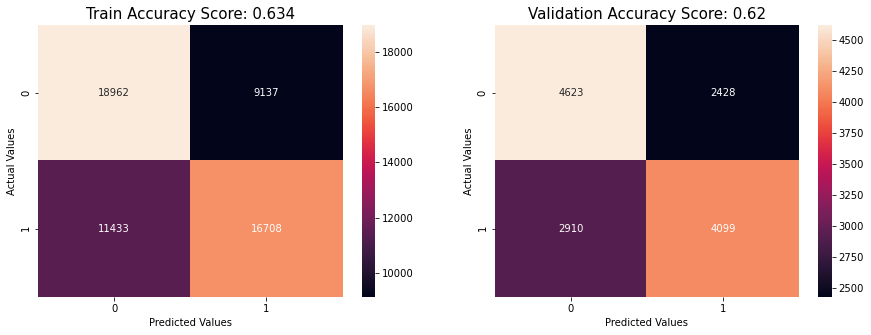

In [69]:
data_obj.confusion_mat(xgb_model, X_train, X_val, y_train, y_val)

Catboost Classifier

In [70]:
#Cat classifier 
cat_model = CatBoostClassifier(random_state = 42, max_depth=3)
cat_model.fit(X_train, y_train,verbose=False)

In [71]:
y_train_preds = cat_model.predict_proba(X_train)[:,1]
y_val_preds = cat_model.predict_proba(X_val)[:,1]

print("CATBOOST")
print('Training:')
catb_train_auc, catb_train_accuracy,catb_train_recall, catb_train_precision,catb_train_fscore,catb_train_specificity = data_obj.model_report(y_train,y_train_preds, thresh)
print('Validation:')
catb_val_auc,catb_val_accuracy, catb_val_recall, catb_val_precision,catb_val_fscore,catb_val_specificity = data_obj.model_report(y_val,y_val_preds, thresh)

CATBOOST
Training:
AUC:0.690
accuracy:0.634
recall:0.586
precision:0.649
fscore:0.616
specificity:0.683
 
Validation:
AUC:0.677
accuracy:0.626
recall:0.580
precision:0.637
fscore:0.607
specificity:0.671
 


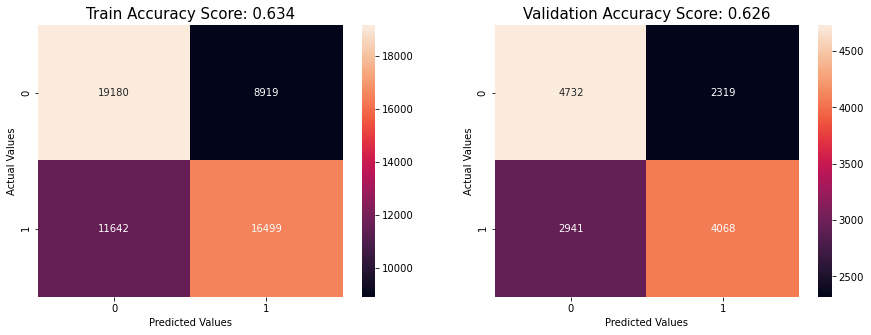

In [72]:
data_obj.confusion_mat(cat_model, X_train, X_val, y_train, y_val)

**Ada Boost Classifier**

In [73]:
ad_model = AdaBoostClassifier(random_state=42, n_estimators=100)
ad_model.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100, random_state=42)

In [74]:
y_train_preds = ad_model.predict_proba(X_train)[:,1]
y_val_preds = ad_model.predict_proba(X_val)[:,1]

print("Ada Boost")
print('Training:')
ad_train_auc, ad_train_accuracy,ad_train_recall, ad_train_precision,ad_train_fscore,ad_train_specificity = data_obj.model_report(y_train,y_train_preds, thresh)
print('Validation:')
ad_val_auc,ad_val_accuracy, ad_val_recall, ad_val_precision,ad_val_fscore,ad_val_specificity = data_obj.model_report(y_val,y_val_preds, thresh)

Ada Boost
Training:
AUC:0.665
accuracy:0.620
recall:0.546
precision:0.641
fscore:0.590
specificity:0.693
 
Validation:
AUC:0.667
accuracy:0.618
recall:0.547
precision:0.636
fscore:0.588
specificity:0.688
 


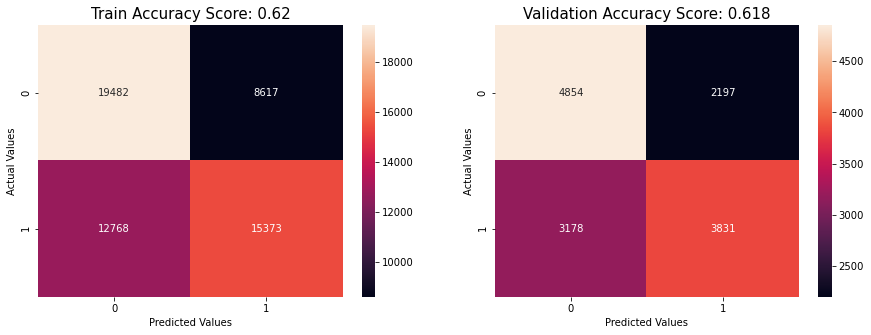

In [75]:
data_obj.confusion_mat(ad_model, X_train, X_val, y_train, y_val)

We use a Stalcking Ensemble method to combine the models and choose the best model from the dataset

In [76]:
#Use CatBoost as the meta learner and the others as the  base estimators.
from sklearn.ensemble import StackingClassifier, ExtraTreesClassifier


estimators = [ ('decision Tree', decision_model),('xgb_classifier', xgb_model), \
              ('ada classifier', ad_model) ]

stack_model = StackingClassifier(estimators=estimators, final_estimator= cat_model, cv= 5, n_jobs= 1, passthrough = True)

stack_model.fit(X_train, y_train)


y_train_preds = stack_model.predict_proba(X_train)[:,1]
y_val_preds = stack_model.predict_proba(X_val)[:,1]



C:\Users\PC\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:27:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\PC\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:27:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\PC\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:27:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\PC\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:27:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\PC\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:27:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\PC\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:27:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.057571
0:	learn: 0.6887608	total: 25.3ms	remaining: 25.3s
1:	learn: 0.6848232	total: 34.9ms	remaining: 17.4s
2:	learn: 0.6812027	total: 43.4ms	remaining: 14.4s
3:	learn: 0.6779018	total: 52.1ms	remaining: 13s
4:	learn: 0.6751968	total: 60.8ms	remaining: 12.1s
5:	learn: 0.6725537	total: 72ms	remaining: 11.9s
6:	learn: 0.6701798	total: 83.8ms	remaining: 11.9s
7:	learn: 0.6681908	total: 94.6ms	remaining: 11.7s
8:	learn: 0.6664676	total: 105ms	remaining: 11.6s
9:	learn: 0.6646759	total: 117ms	remaining: 11.6s
10:	learn: 0.6630661	total: 129ms	remaining: 11.6s
11:	learn: 0.6617261	total: 138ms	remaining: 11.3s
12:	learn: 0.6604354	total: 149ms	remaining: 11.3s
13:

170:	learn: 0.6452807	total: 1.63s	remaining: 7.9s
171:	learn: 0.6452646	total: 1.64s	remaining: 7.89s
172:	learn: 0.6452607	total: 1.65s	remaining: 7.89s
173:	learn: 0.6452441	total: 1.66s	remaining: 7.87s
174:	learn: 0.6452419	total: 1.67s	remaining: 7.86s
175:	learn: 0.6452349	total: 1.68s	remaining: 7.84s
176:	learn: 0.6452306	total: 1.68s	remaining: 7.83s
177:	learn: 0.6452231	total: 1.69s	remaining: 7.82s
178:	learn: 0.6452077	total: 1.7s	remaining: 7.8s
179:	learn: 0.6452015	total: 1.71s	remaining: 7.79s
180:	learn: 0.6451881	total: 1.72s	remaining: 7.77s
181:	learn: 0.6451736	total: 1.73s	remaining: 7.75s
182:	learn: 0.6451712	total: 1.73s	remaining: 7.75s
183:	learn: 0.6451452	total: 1.74s	remaining: 7.74s
184:	learn: 0.6451227	total: 1.75s	remaining: 7.72s
185:	learn: 0.6451043	total: 1.76s	remaining: 7.71s
186:	learn: 0.6450896	total: 1.77s	remaining: 7.7s
187:	learn: 0.6450796	total: 1.78s	remaining: 7.68s
188:	learn: 0.6450598	total: 1.79s	remaining: 7.67s
189:	learn: 0.64

345:	learn: 0.6430078	total: 3.25s	remaining: 6.15s
346:	learn: 0.6429862	total: 3.26s	remaining: 6.14s
347:	learn: 0.6429786	total: 3.27s	remaining: 6.13s
348:	learn: 0.6429767	total: 3.29s	remaining: 6.13s
349:	learn: 0.6429622	total: 3.29s	remaining: 6.12s
350:	learn: 0.6429617	total: 3.31s	remaining: 6.11s
351:	learn: 0.6429528	total: 3.32s	remaining: 6.11s
352:	learn: 0.6429341	total: 3.33s	remaining: 6.1s
353:	learn: 0.6429182	total: 3.34s	remaining: 6.1s
354:	learn: 0.6429057	total: 3.35s	remaining: 6.09s
355:	learn: 0.6428916	total: 3.37s	remaining: 6.09s
356:	learn: 0.6428740	total: 3.38s	remaining: 6.08s
357:	learn: 0.6428729	total: 3.39s	remaining: 6.07s
358:	learn: 0.6428623	total: 3.4s	remaining: 6.06s
359:	learn: 0.6428618	total: 3.41s	remaining: 6.06s
360:	learn: 0.6428439	total: 3.42s	remaining: 6.05s
361:	learn: 0.6428388	total: 3.43s	remaining: 6.04s
362:	learn: 0.6428144	total: 3.44s	remaining: 6.03s
363:	learn: 0.6427928	total: 3.44s	remaining: 6.02s
364:	learn: 0.6

506:	learn: 0.6412530	total: 4.87s	remaining: 4.74s
507:	learn: 0.6412468	total: 4.88s	remaining: 4.73s
508:	learn: 0.6412332	total: 4.89s	remaining: 4.72s
509:	learn: 0.6412322	total: 4.9s	remaining: 4.71s
510:	learn: 0.6412081	total: 4.91s	remaining: 4.7s
511:	learn: 0.6411934	total: 4.92s	remaining: 4.69s
512:	learn: 0.6411807	total: 4.93s	remaining: 4.68s
513:	learn: 0.6411587	total: 4.94s	remaining: 4.67s
514:	learn: 0.6411439	total: 4.95s	remaining: 4.66s
515:	learn: 0.6411330	total: 4.96s	remaining: 4.65s
516:	learn: 0.6411162	total: 4.97s	remaining: 4.64s
517:	learn: 0.6411123	total: 4.98s	remaining: 4.64s
518:	learn: 0.6410995	total: 4.99s	remaining: 4.63s
519:	learn: 0.6410855	total: 5s	remaining: 4.62s
520:	learn: 0.6410761	total: 5.01s	remaining: 4.61s
521:	learn: 0.6410630	total: 5.02s	remaining: 4.6s
522:	learn: 0.6410553	total: 5.03s	remaining: 4.59s
523:	learn: 0.6410443	total: 5.04s	remaining: 4.58s
524:	learn: 0.6410268	total: 5.05s	remaining: 4.57s
525:	learn: 0.6410

670:	learn: 0.6394070	total: 6.49s	remaining: 3.18s
671:	learn: 0.6394057	total: 6.5s	remaining: 3.17s
672:	learn: 0.6394046	total: 6.51s	remaining: 3.16s
673:	learn: 0.6394045	total: 6.51s	remaining: 3.15s
674:	learn: 0.6394036	total: 6.53s	remaining: 3.14s
675:	learn: 0.6393947	total: 6.53s	remaining: 3.13s
676:	learn: 0.6393850	total: 6.54s	remaining: 3.12s
677:	learn: 0.6393783	total: 6.55s	remaining: 3.11s
678:	learn: 0.6393761	total: 6.56s	remaining: 3.1s
679:	learn: 0.6393654	total: 6.57s	remaining: 3.09s
680:	learn: 0.6393554	total: 6.58s	remaining: 3.08s
681:	learn: 0.6393340	total: 6.59s	remaining: 3.07s
682:	learn: 0.6393222	total: 6.6s	remaining: 3.06s
683:	learn: 0.6393142	total: 6.61s	remaining: 3.05s
684:	learn: 0.6393083	total: 6.62s	remaining: 3.04s
685:	learn: 0.6393076	total: 6.62s	remaining: 3.03s
686:	learn: 0.6393009	total: 6.63s	remaining: 3.02s
687:	learn: 0.6392891	total: 6.64s	remaining: 3.01s
688:	learn: 0.6392829	total: 6.65s	remaining: 3s
689:	learn: 0.6392

842:	learn: 0.6378333	total: 8.1s	remaining: 1.51s
843:	learn: 0.6378190	total: 8.11s	remaining: 1.5s
844:	learn: 0.6378139	total: 8.12s	remaining: 1.49s
845:	learn: 0.6378038	total: 8.13s	remaining: 1.48s
846:	learn: 0.6377927	total: 8.14s	remaining: 1.47s
847:	learn: 0.6377747	total: 8.15s	remaining: 1.46s
848:	learn: 0.6377602	total: 8.16s	remaining: 1.45s
849:	learn: 0.6377450	total: 8.17s	remaining: 1.44s
850:	learn: 0.6377315	total: 8.18s	remaining: 1.43s
851:	learn: 0.6377196	total: 8.19s	remaining: 1.42s
852:	learn: 0.6377067	total: 8.19s	remaining: 1.41s
853:	learn: 0.6376997	total: 8.2s	remaining: 1.4s
854:	learn: 0.6376992	total: 8.21s	remaining: 1.39s
855:	learn: 0.6376988	total: 8.22s	remaining: 1.38s
856:	learn: 0.6376950	total: 8.23s	remaining: 1.37s
857:	learn: 0.6376808	total: 8.24s	remaining: 1.36s
858:	learn: 0.6376768	total: 8.25s	remaining: 1.35s
859:	learn: 0.6376612	total: 8.26s	remaining: 1.34s
860:	learn: 0.6376438	total: 8.26s	remaining: 1.33s
861:	learn: 0.63

In [77]:
print("")


print("Stacked Model")
print('Training:')
s_train_auc, s_train_accuracy, s_train_recall, s_train_precision, s_train_fscore, s_train_specificity = data_obj.model_report(y_train,y_train_preds, thresh)
print('Validation:')
s_val_auc, s_val_accuracy, s_val_recall, s_val_precision,s_val_fscore, s_val_specificity = data_obj.model_report(y_val,y_val_preds, thresh)

#https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/


Stacked Model
Training:
AUC:0.691
accuracy:0.635
recall:0.586
precision:0.650
fscore:0.616
specificity:0.683
 
Validation:
AUC:0.675
accuracy:0.625
recall:0.579
precision:0.636
fscore:0.606
specificity:0.671
 


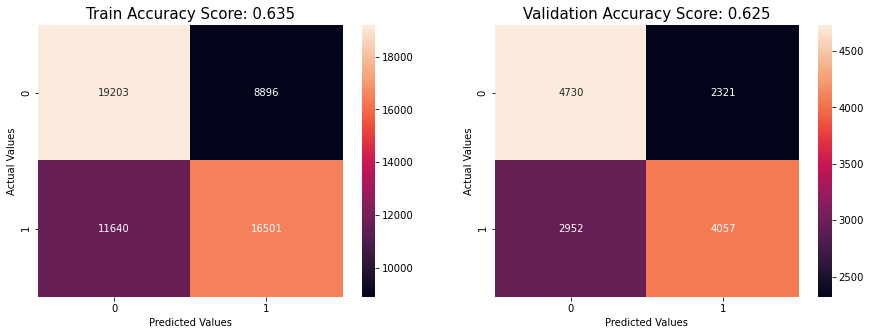

In [78]:
data_obj.confusion_mat(stack_model, X_train, X_val, y_train, y_val)

In [79]:
#Compile the model performance into a dictionary and then concert to dataframe
base_models_results = pd.DataFrame({'classifier':['STC', 'STC', 'DC', 'DC','RF','RF','XGB','XGB','CATB','CATB', 'ADA', 'ADA',],
                           'data_set':['train','val']*6,
                          'auc':[s_train_auc,s_val_auc,dc_train_auc,dc_val_auc,rf_train_auc,rf_val_auc, xgb_train_auc,xgb_val_auc,\
                                 catb_train_auc,catb_val_auc, ad_train_auc,ad_val_auc],
                                    
                          'accuracy':[s_train_accuracy,s_val_accuracy, dc_train_accuracy,dc_val_accuracy,rf_train_accuracy,rf_val_accuracy,\
                                      xgb_train_accuracy,xgb_val_accuracy, catb_train_accuracy,catb_val_accuracy, ad_train_accuracy,ad_val_accuracy],
                                    
                          'recall':[s_train_recall,s_val_recall,dc_train_recall,dc_val_recall,rf_train_recall,rf_val_recall, xgb_train_recall,xgb_val_recall,\
                                    catb_train_recall,catb_val_recall,  ad_train_recall,ad_val_recall],
                                    
                          'precision':[s_train_precision,s_val_precision, dc_train_precision,dc_val_precision,rf_train_precision,rf_val_precision, xgb_train_precision,xgb_val_precision,\
                                       catb_train_precision,catb_val_precision, ad_train_precision,ad_val_precision],
                          'fscore':[s_train_fscore,s_val_fscore, dc_train_fscore,dc_val_fscore,rf_train_fscore,rf_val_fscore, xgb_train_fscore,xgb_val_fscore,\
                                    catb_train_fscore,catb_val_fscore,  ad_train_fscore,ad_val_fscore],
                          'specificity':[s_train_specificity,s_val_specificity, dc_train_specificity,dc_val_specificity,rf_train_specificity,rf_val_specificity,xgb_train_specificity,xgb_val_specificity,\
                                         catb_train_specificity,catb_val_specificity, ad_train_specificity,ad_val_specificity]})
base_models_results

classifier data_set       auc  accuracy    recall  precision    fscore  \
0         STC    train  0.690514  0.634851  0.586369   0.649722  0.616422   
1         STC      val  0.675078  0.624964  0.578827   0.636093  0.606110   
2          DC    train  0.644998  0.610473  0.540528   0.628866  0.581360   
3          DC      val  0.646982  0.613087  0.544443   0.629391  0.583843   
4          RF    train  0.654144  0.611220  0.522476   0.635668  0.573541   
5          RF      val  0.657086  0.615434  0.532744   0.636550  0.580039   
6         XGB    train  0.689472  0.634246  0.593724   0.646469  0.618975   
7         XGB      val  0.674297  0.620341  0.584820   0.628007  0.605644   
8        CATB    train  0.689595  0.634406  0.586298   0.649107  0.616106   
9        CATB      val  0.676971  0.625889  0.580397   0.636919  0.607345   
10        ADA    train  0.665227  0.619755  0.546285   0.640809  0.589783   
11        ADA      val  0.666609  0.617710  0.546583   0.635534  0.587712   

    specificity  
0      0.683405  
1      0.670827  
2      0.680522  
3      0.681322  
4      0.700096  
5      0.697632  
6      0.674828  
7      0.655652  
8      0.682587  
9      0.671110  
10     0.693334  
11     0.688413

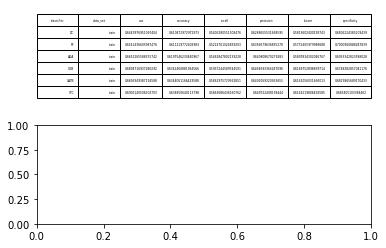

In [80]:
#Plot a table for the train data metrics alone
data_obj.metrics_table(base_models_results, "train")

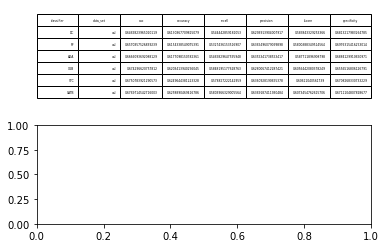

In [81]:
#Plot a table for the validation data metrics alone
data_obj.metrics_table(base_models_results, "val")

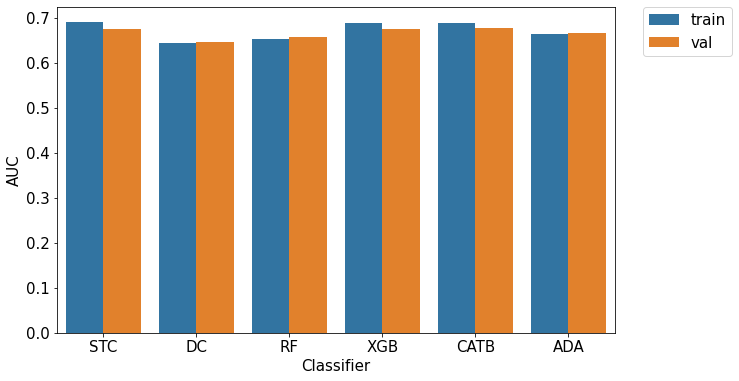

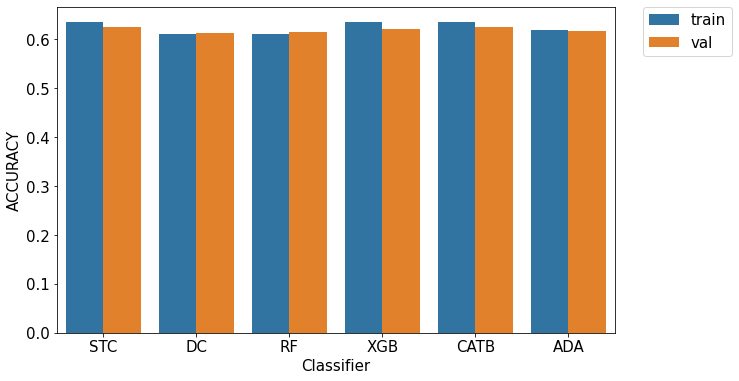

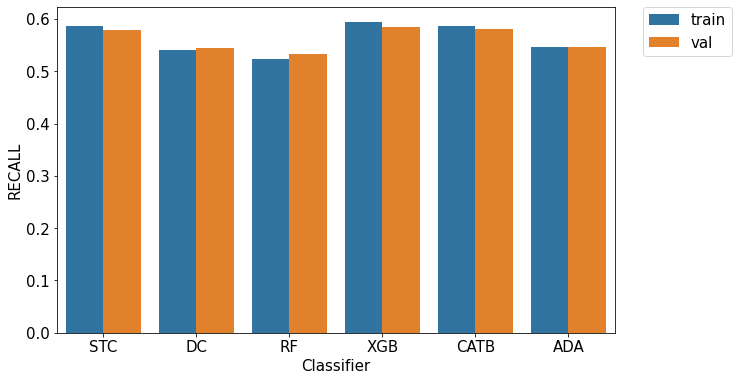

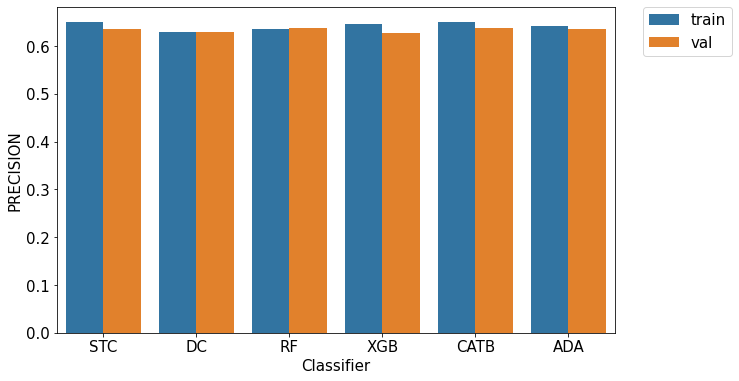

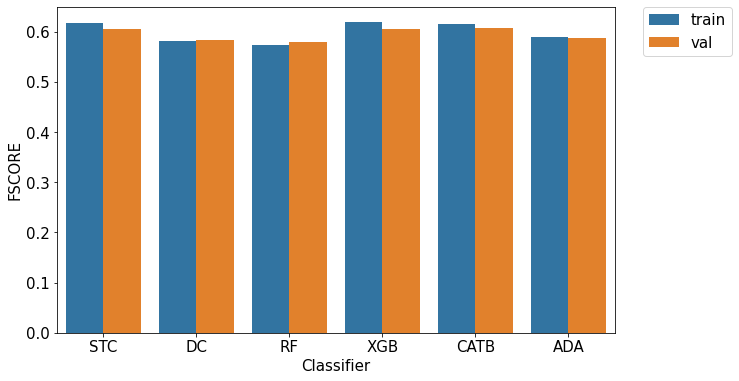

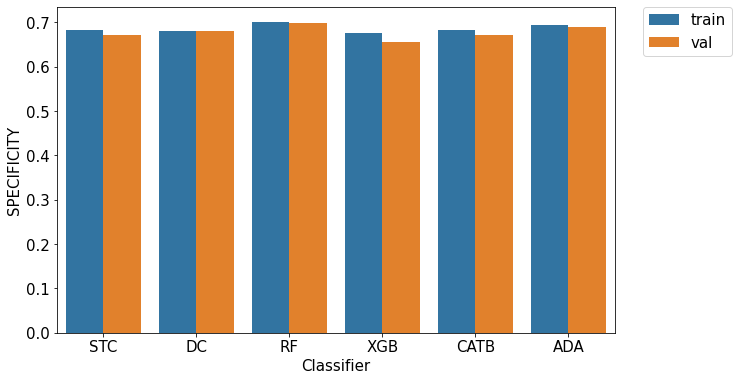

In [82]:
metrics = ["auc", "accuracy", "recall", "precision", "fscore", "specificity"]
for col in metrics:
    data_obj.show_metrics(col)

**CLUSTERING AND DIMENSIONALITY REDUCTION** <br>
We used both PCA and TSNE to cluster the dataset. <br>
We applied PCA to reduce the Principal Components and we selected components that expalins about 90% variability of the dataset.



Reduce the Dimension of the Dataset with PCA

In [83]:
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

X_train_pca = scaler.fit_transform(X_train_pca)
X_test_pca = scaler.transform(X_test_pca)
X_train_pca


array([[0.17476737, 0.02814503, 0.43242439, ..., 0.43639022, 0.30365482,
        0.34406438],
       [0.05533795, 0.8719737 , 0.67846228, ..., 0.70271793, 0.44886418,
        0.12634424],
       [0.97901331, 0.98507109, 0.55957492, ..., 0.42218192, 0.34105629,
        0.26892404],
       ...,
       [0.09677752, 0.05066864, 0.60477514, ..., 0.30644185, 0.34139372,
        0.13223738],
       [0.98710149, 0.06352659, 0.64976837, ..., 0.43105626, 0.38702529,
        0.33441416],
       [0.24292111, 0.90402193, 0.86610218, ..., 0.32574526, 0.38652615,
        0.22914122]])

Text(0, 0.5, 'Second Principal Component')

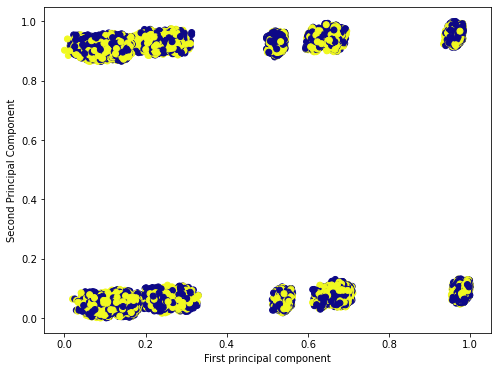

In [84]:
plt.figure(figsize=(8,6))
plt.scatter(X_train_pca[:,0],X_train_pca[:,1],c=y_train,cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

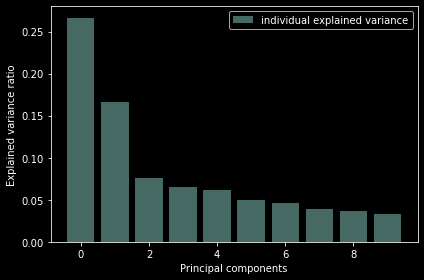

In [85]:
with plt.style.context('dark_background'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(10), pca.explained_variance_ratio_, alpha=0.5, align='center',
            label='individual explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

In [86]:
tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_tsne = tsne.fit_transform(X_train)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 56240 samples in 0.002s...
[t-SNE] Computed neighbors for 56240 samples in 81.682s...
[t-SNE] Computed conditional probabilities for sample 1000 / 56240
[t-SNE] Computed conditional probabilities for sample 2000 / 56240
[t-SNE] Computed conditional probabilities for sample 3000 / 56240
[t-SNE] Computed conditional probabilities for sample 4000 / 56240
[t-SNE] Computed conditional probabilities for sample 5000 / 56240
[t-SNE] Computed conditional probabilities for sample 6000 / 56240
[t-SNE] Computed conditional probabilities for sample 7000 / 56240
[t-SNE] Computed conditional probabilities for sample 8000 / 56240
[t-SNE] Computed conditional probabilities for sample 9000 / 56240
[t-SNE] Computed conditional probabilities for sample 10000 / 56240
[t-SNE] Computed conditional probabilities for sample 11000 / 56240
[t-SNE] Computed conditional probabilities for sample 12000 / 56240
[t-SNE] Computed conditional probabilities for s

C:\Users\PC\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


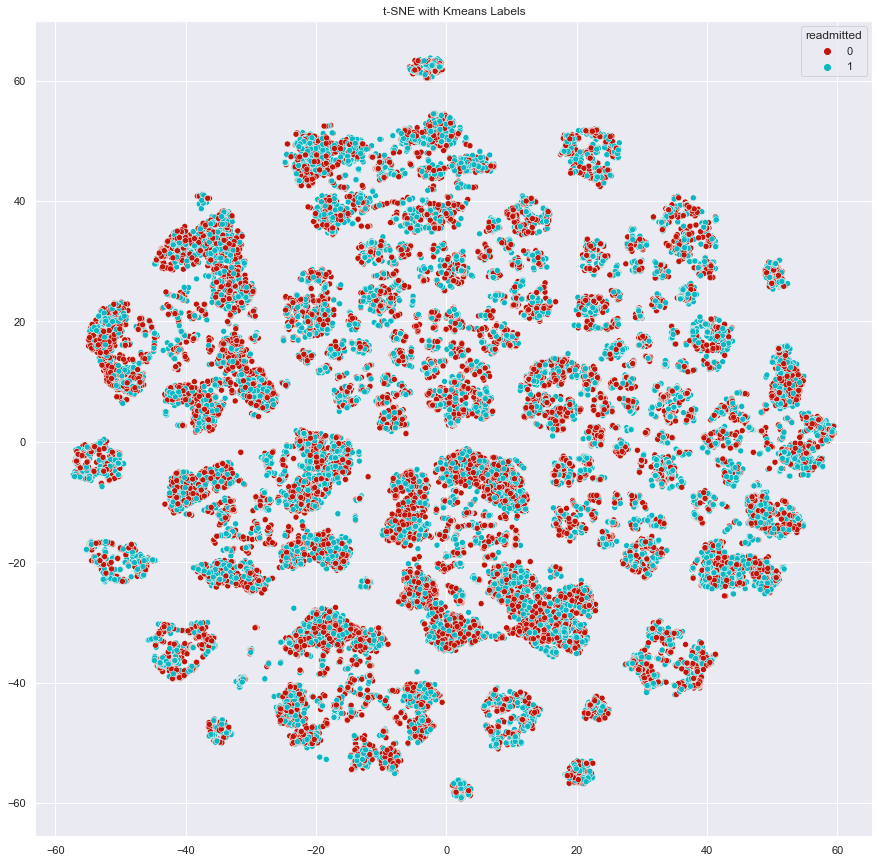

In [87]:

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(2, l=.4, s=.9)

# plot
sns.scatterplot(X_tsne[:,0], X_tsne[:,1], hue=y_train, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
#plt.savefig("improved_cluster_tsne.png")
plt.show()

As seen from the PCA the data is not well dividedbetween the classes. Therefore we used t to see if the classes will be clearly divided

In [88]:
#PCA SOM
#https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
#Clustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
pca = PCA(0.95)
pca_result = pca.fit_transform(X_train)
pca_df = pd.DataFrame()
pca_df['pca-one'] = pca_result[:,0]
pca_df['pca-two'] = pca_result[:,1] 
pca_df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
#Explained variation per principal component: [0.09746116 0.07155445 0.06149531]


Explained variation per principal component: [0.26662422 0.16623579 0.07610158 0.06512068 0.06115286 0.04913829
 0.04584273 0.03890562 0.03689793 0.03300535 0.0277289  0.0233786
 0.02125027 0.01693581 0.01578832 0.01087805]


Text(0, 0.5, 'Cumulative explained variance')

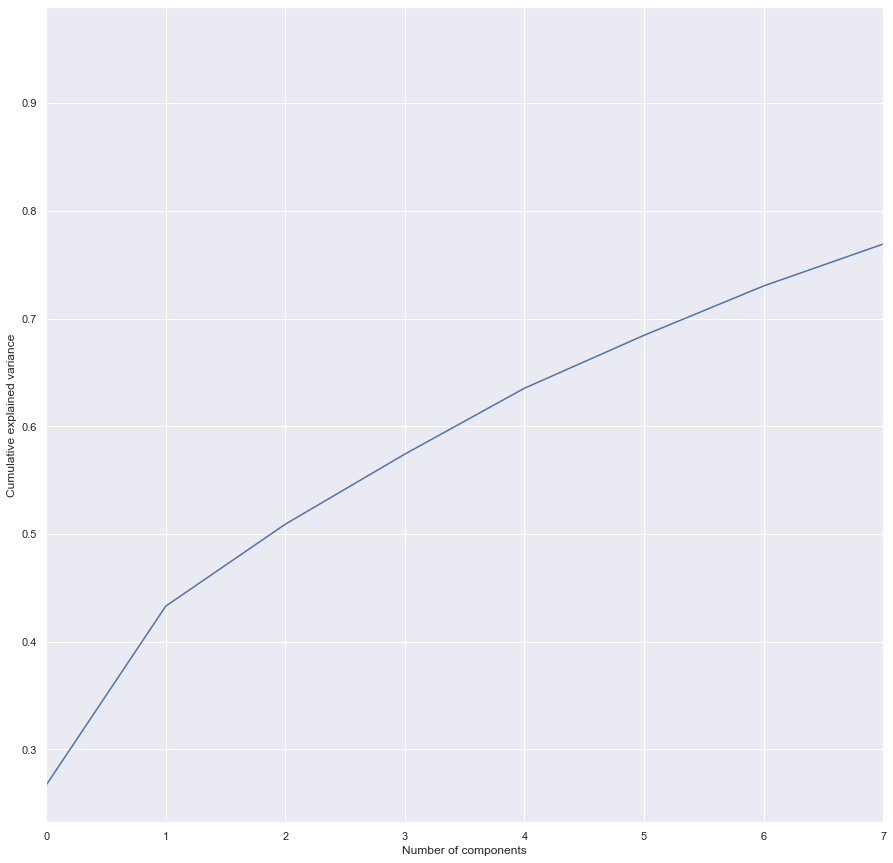

In [89]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,7,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

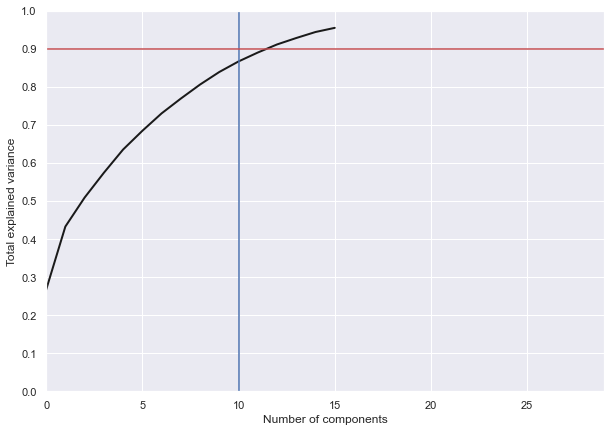

In [90]:
#First we calculate the number of components that explains 87% of variability in the dataset
#We then choose this number of components as out Principlal components in the Project
pca_r = pca.fit(X_train)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca_r.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 29)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(10, c='b')
plt.axhline(0.90, c='r')
plt.show();

Plot the Model Importance using xgboost **plot_importance() method**

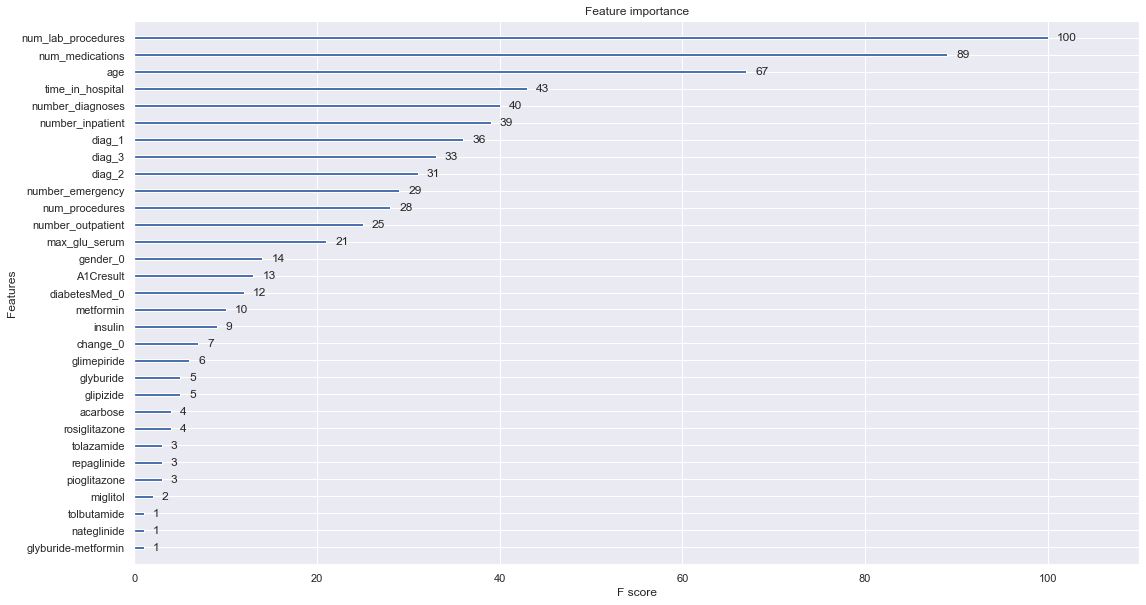

In [91]:


plt.rcParams["figure.figsize"] = (18, 10)
plot_importance(xgb_model)

ft_imp = pd.Series(cat_model.feature_importances_, index = X_train.columns)
best_features = ft_imp.nlargest(20)

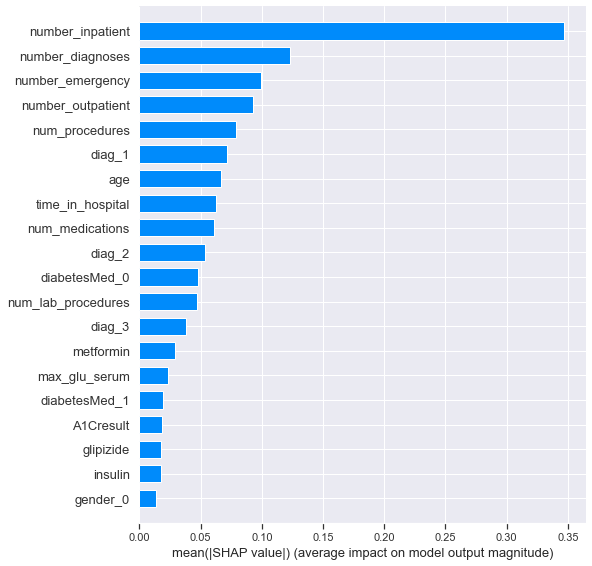

In [92]:
import shap
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_train, y_train,)
#shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])
#shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [93]:
best_features.index

Index(['number_inpatient', 'num_lab_procedures', 'number_diagnoses', 'age',
       'number_emergency', 'num_medications', 'diag_1', 'number_outpatient',
       'time_in_hospital', 'num_procedures', 'max_glu_serum', 'diag_3',
       'diag_2', 'diabetesMed_0', 'A1Cresult', 'metformin', 'insulin',
       'glipizide', 'diabetesMed_1', 'pioglitazone'],
      dtype='object')

In [94]:
X_train_imp = X_train[best_features.index]
X_val_imp = X_val[best_features.index]
X_test_imp = X_test[best_features.index]

    Hyper Parameter Tuning 
 To obtain the set of parameters that give the best performance we use the **GridSearchCV() method**

1. **Decision Tree Classifier Parameter Tuning**

In [95]:
dc = DecisionTreeClassifier()
#A dictionary of parameter with different values, the GridSearch obtain a value such that it has the highest performance
dc_params={"criterion":["gini", "entropy"],
           #--"max_features": [15, 20, 25, 30],
             "max_depth": [5,8, 10],
            "splitter":["best", "random"],
             "max_leaf_nodes": [10, 15, 20],
              "random_state":[0,10, 42]}

**Note:** The GridSearchCV makes system very slow. So I commented it out. Please, remove the **"#"** comment symbol to run the code

In [96]:
#dc_cv_model=GridSearchCV(dc,dc_params, cv=5, n_jobs=-1,  verbose=2).fit(X_train,y_train)

In [97]:
#dc_cv_model.best_params_

In [98]:
dc_tuned =DecisionTreeClassifier(criterion="entropy", max_depth=8, max_leaf_nodes=20, splitter='best', random_state=0).fit(X_train, y_train)

In [99]:
dc_train_auc_base, dc_val_auc_base,  dc_train_auc, dc_val_auc = \
data_obj.compare_parameters(" DECISION TREE", decision_model, dc_tuned, X_train, X_val)

Baseline  DECISION TREE
Training AUC:0.645
Validation AUC:0.647
Optimized DECISION TREE
Training AUC:0.652
Validation AUC:0.653


In [100]:
dc_tuned_ =DecisionTreeClassifier(criterion="gini", max_depth=8, max_leaf_nodes=15, splitter='best', random_state=0).fit(X_train_imp, y_train)
dc_train_auc_base, dc_val_auc_base,  dc_train_auc, dc_val_auc = \
data_obj.compare_parameters(" DECISION TREE", decision_model, dc_tuned_, X_train_imp, X_val_imp)

Baseline  DECISION TREE
Training AUC:0.645
Validation AUC:0.647
Optimized DECISION TREE
Training AUC:0.650
Validation AUC:0.652


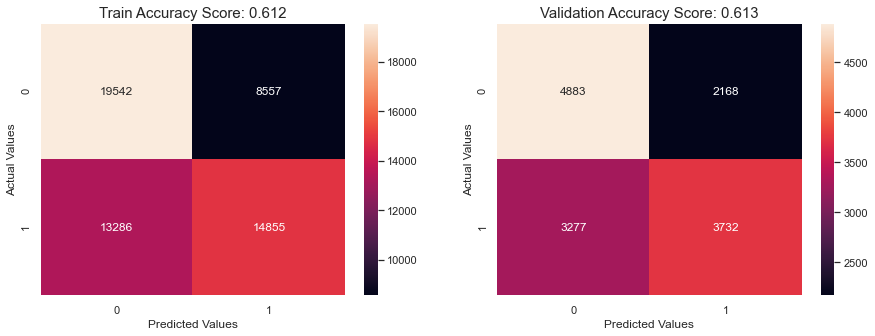

In [101]:
data_obj.confusion_mat(dc_tuned, X_train, X_val, y_train, y_val)

**Note2**: We observed that the Feature Importance led to the reduction of the AUC, so we will continue with the features. Will use PCA for dimensionality reduction

2. **Random Forest Bagging Ensemble Method Parameter Tuning**

In [102]:
random_forest_params = {
    'max_depth':[5, 8, 10],
    'max_features': [5, 10, 15],
    'min_samples_split': [2,3],
    'n_estimators': [700, 800]
            }

**Note:** The GridSearchCV makes system very slow. So I commented it out. Please, remove the **"#"** comment symbol to run the code

In [103]:
random_forest = RandomForestClassifier()
#rf_cv_model = GridSearchCV(random_forest, random_forest_params, n_jobs=-1, verbose=2).fit(X_train, y_train)

In [104]:
#rf_cv_model.best_params_


In [105]:
rf_tuned =RandomForestClassifier(max_depth=10,
                                 max_features=5,
                                 min_samples_split=3,
                                 n_estimators=800).fit(X_train, y_train)

In [106]:

rf_train_auc_base, rf_val_auc_base,  rf_train_auc, rf_val_auc = \
data_obj.compare_parameters(" Random Forest", random_forest_model, rf_tuned, X_train, X_val)


Baseline  Random Forest
Training AUC:0.654
Validation AUC:0.657
Optimized Random Forest
Training AUC:0.722
Validation AUC:0.671


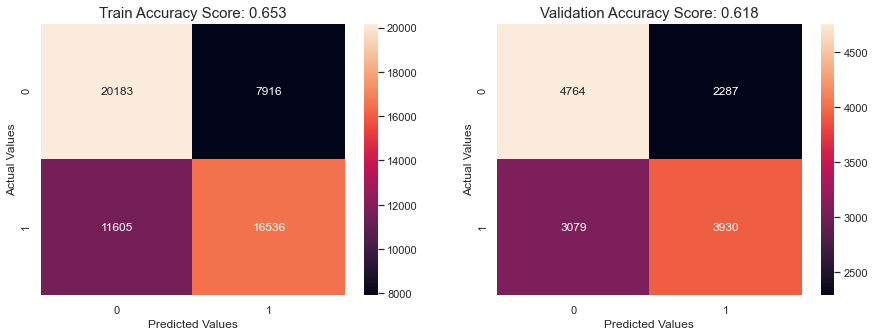

In [107]:
data_obj.confusion_mat(rf_tuned, X_train, X_val, y_train, y_val)

In [108]:
rf_tuned_ =RandomForestClassifier(max_depth=8,
                                 max_features=5,
                                 min_samples_split=10,
                                 n_estimators=700).fit(X_train_imp, y_train)

In [109]:
rf_train_auc_base, rf_val_auc_base,  rf_train_auc, rf_val_auc = \
data_obj.compare_parameters(" Random Forest", random_forest_model, rf_tuned_, X_train_imp, X_val_imp)

Baseline  Random Forest
Training AUC:0.654
Validation AUC:0.657
Optimized Random Forest
Training AUC:0.687
Validation AUC:0.668


From the Above, Feature Selection doesnt improve the Random Forest Model

3. **XGB Boosting Ensemble Classifier Parameter Tunning.** 

**Note:** The GridSearchCV makes system very slow. So I commented it out. Please, remove the "#" comment symbol to run the code

In [110]:
xgb_mod = XGBClassifier()

grad_model_params = {
    'booster':['gbtree', 'dart'],
    "max_depth": [2,5,8],
    "sampling_method": ['uniform','gradient_based'],
    'eta': [0.1, 0.01, 0.05],
    'n_jobs': [-1, 1]
            }
#grad_cv_model = GridSearchCV(xgb_mod, grad_model_params, n_jobs=-1, verbose=2).fit(X_train, y_train)

In [111]:
#grad_cv_model.best_params_
#use this to tune this

In [112]:
xgb_tuned =XGBClassifier(booster="gbtree", eta=0.32, max_depth=3, n_jobs=1, sampling_method='uniform', random_state=42).fit(X_train, y_train)
xgb_train_auc_base, xgb_val_auc_base,  xgb_train_auc, xgb_val_auc = \
data_obj.compare_parameters("XGB Classifier", xgb_model, xgb_tuned, X_train, X_val)

[13:39:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


Baseline XGB Classifier
Training AUC:0.689
Validation AUC:0.674
OptimizedXGB Classifier
Training AUC:0.690
Validation AUC:0.675


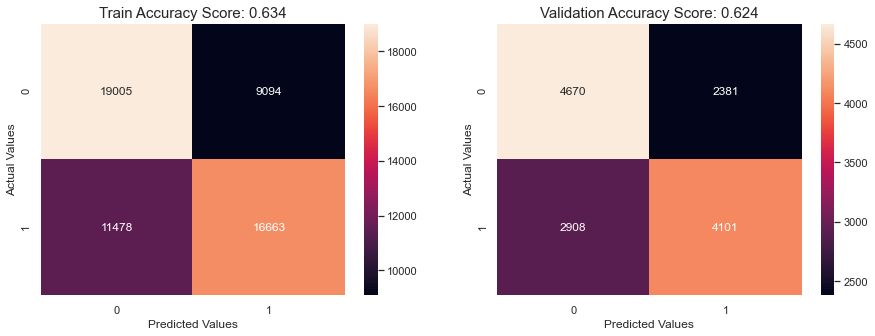

In [113]:
data_obj.confusion_mat(xgb_tuned, X_train, X_val, y_train, y_val)

4. Catboost Classifier (Boosting Ensemble) Hyper Parameter Tuning

In [114]:
catb=CatBoostClassifier()
catb_params={"iterations":[200,500,1000],
            "learning_rate":[0.05,0.1],
            "depth":[4,5,8]}

**Note:** The GridSearchCV makes system very slow. So I commented it out. Please, remove the "#" comment symbol to run the code

In [115]:
#catb_cv_model=GridSearchCV(catb,catb_params,cv = 3, n_jobs=-1,  verbose=2).fit(X_train,y_train)

In [116]:
#catb_cv_model.best_params_

In [117]:
catb_tuned =CatBoostClassifier(depth=4,iterations=500,learning_rate=0.1).fit(X_train, y_train)

0:	learn: 0.6869528	total: 29.9ms	remaining: 14.9s
1:	learn: 0.6816927	total: 40ms	remaining: 9.97s
2:	learn: 0.6782404	total: 50.6ms	remaining: 8.38s
3:	learn: 0.6743775	total: 60.2ms	remaining: 7.47s
4:	learn: 0.6715219	total: 70.4ms	remaining: 6.97s
5:	learn: 0.6691951	total: 80.3ms	remaining: 6.61s
6:	learn: 0.6668757	total: 89.6ms	remaining: 6.31s
7:	learn: 0.6650123	total: 99.7ms	remaining: 6.13s
8:	learn: 0.6632871	total: 109ms	remaining: 5.96s
9:	learn: 0.6621730	total: 123ms	remaining: 6.05s
10:	learn: 0.6609867	total: 135ms	remaining: 5.98s
11:	learn: 0.6600307	total: 144ms	remaining: 5.85s
12:	learn: 0.6590573	total: 155ms	remaining: 5.79s
13:	learn: 0.6583672	total: 163ms	remaining: 5.67s
14:	learn: 0.6576874	total: 172ms	remaining: 5.58s
15:	learn: 0.6570820	total: 182ms	remaining: 5.49s
16:	learn: 0.6564843	total: 192ms	remaining: 5.46s
17:	learn: 0.6561200	total: 202ms	remaining: 5.4s
18:	learn: 0.6556570	total: 212ms	remaining: 5.37s
19:	learn: 0.6551734	total: 224ms	re

176:	learn: 0.6392270	total: 2.04s	remaining: 3.73s
177:	learn: 0.6391899	total: 2.05s	remaining: 3.72s
178:	learn: 0.6390946	total: 2.07s	remaining: 3.71s
179:	learn: 0.6390366	total: 2.08s	remaining: 3.69s
180:	learn: 0.6389722	total: 2.09s	remaining: 3.68s
181:	learn: 0.6389092	total: 2.1s	remaining: 3.67s
182:	learn: 0.6388654	total: 2.11s	remaining: 3.65s
183:	learn: 0.6387975	total: 2.12s	remaining: 3.64s
184:	learn: 0.6387366	total: 2.13s	remaining: 3.63s
185:	learn: 0.6386849	total: 2.15s	remaining: 3.63s
186:	learn: 0.6386494	total: 2.16s	remaining: 3.62s
187:	learn: 0.6385897	total: 2.17s	remaining: 3.61s
188:	learn: 0.6385508	total: 2.18s	remaining: 3.6s
189:	learn: 0.6384996	total: 2.19s	remaining: 3.58s
190:	learn: 0.6384325	total: 2.21s	remaining: 3.57s
191:	learn: 0.6383756	total: 2.22s	remaining: 3.56s
192:	learn: 0.6383194	total: 2.23s	remaining: 3.54s
193:	learn: 0.6382569	total: 2.24s	remaining: 3.53s
194:	learn: 0.6381917	total: 2.25s	remaining: 3.52s
195:	learn: 0.

337:	learn: 0.6322709	total: 3.86s	remaining: 1.85s
338:	learn: 0.6322166	total: 3.87s	remaining: 1.84s
339:	learn: 0.6321648	total: 3.88s	remaining: 1.83s
340:	learn: 0.6321590	total: 3.89s	remaining: 1.81s
341:	learn: 0.6321425	total: 3.9s	remaining: 1.8s
342:	learn: 0.6321048	total: 3.92s	remaining: 1.79s
343:	learn: 0.6320659	total: 3.93s	remaining: 1.78s
344:	learn: 0.6320372	total: 3.94s	remaining: 1.77s
345:	learn: 0.6319924	total: 3.95s	remaining: 1.76s
346:	learn: 0.6319534	total: 3.96s	remaining: 1.75s
347:	learn: 0.6319140	total: 3.97s	remaining: 1.74s
348:	learn: 0.6318978	total: 3.99s	remaining: 1.72s
349:	learn: 0.6318477	total: 4s	remaining: 1.71s
350:	learn: 0.6317909	total: 4.01s	remaining: 1.7s
351:	learn: 0.6317690	total: 4.02s	remaining: 1.69s
352:	learn: 0.6317205	total: 4.03s	remaining: 1.68s
353:	learn: 0.6316902	total: 4.04s	remaining: 1.67s
354:	learn: 0.6316381	total: 4.05s	remaining: 1.66s
355:	learn: 0.6316147	total: 4.06s	remaining: 1.64s
356:	learn: 0.6315

In [118]:
#data_obj.compare_parameters("CATBOOST", cat_model, catb_tuned)
cb_train_auc_base, cb_val_auc_base,  cb_train_auc, cb_val_auc = \
data_obj.compare_parameters(" CATBOOST", cat_model, catb_tuned, X_train, X_val)

Baseline  CATBOOST
Training AUC:0.690
Validation AUC:0.677
Optimized CATBOOST
Training AUC:0.701
Validation AUC:0.677


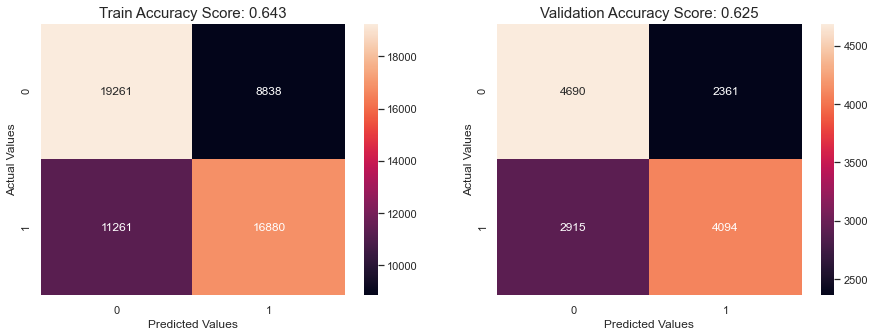

In [119]:
data_obj.confusion_mat(catb_tuned, X_train, X_val, y_train, y_val)

5. **Ada Boost Classifier** 

In [120]:
ada = AdaBoostClassifier()
ada_model_params = {'algorithm': ['SAMME.R', 'SAMME'],
                
                 'learning_rate': [0.05,0.1],
                 'n_estimators': [200,500,700],
                 'random_state': [0, 42]}


**Note:** The GridSearchCV makes system very slow. So I commented it out. Please, remove the "#" comment symbol to run the code

In [121]:
#ada_cv_model=GridSearchCV(ada,ada_model_params, n_jobs=-1,  verbose=2).fit(X_train,y_train)

In [122]:
#ada_cv_model.best_params_

In [123]:
ada_tuned = AdaBoostClassifier(algorithm='SAMME.R',learning_rate=0.1, n_estimators=700,random_state= 0).fit(X_train, y_train)

In [124]:
#data_obj.compare_parameters("CATBOOST", cat_model, catb_tuned)
adt_train_auc_base, adt_val_auc_base,  adt_train_auc, adt_val_auc = \
data_obj.compare_parameters(" Ada", ad_model, ada_tuned, X_train, X_val)

Baseline  Ada
Training AUC:0.665
Validation AUC:0.667
Optimized Ada
Training AUC:0.665
Validation AUC:0.667


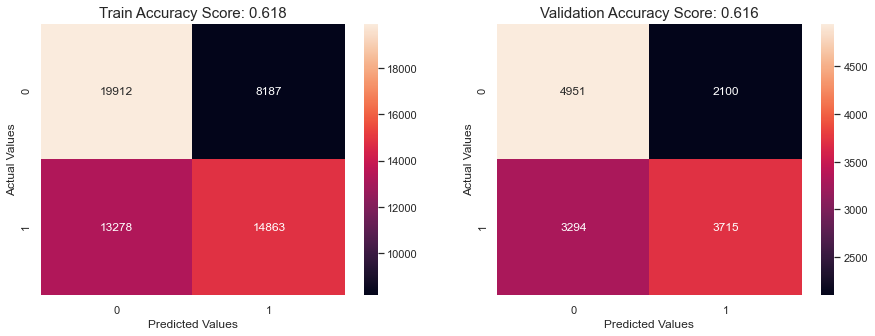

In [125]:
data_obj.confusion_mat(ada_tuned, X_train, X_val, y_train, y_val)

6. **Stack Ensemble Method** Bringing it all together

In [126]:
#Stack = DecisionTreeClassifier()
estimators = [ ('decision Tree', dc_tuned), ('random forest', rf_tuned), ('xgb_classifier', xgb_tuned), \
              ('ada classifier', ada_tuned) ]

stack_tuned = StackingClassifier(estimators=estimators, final_estimator= catb_tuned, cv= 5, n_jobs= 1, passthrough = True)

stack_tuned.fit(X_train, y_train)


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[13:40:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[13:42:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[13:43:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[13:43:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[13:43:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[13:43:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.6853218	total: 32ms	remaining: 16s
1:	learn: 0.6787648	total: 48.8ms	remaining: 12.1s
2:	learn: 0.6733906	total: 64.5ms	remaining: 10.7s
3:	learn: 0.6691775	total: 80.2ms	remaining: 9.94s
4:	learn: 0.6656492	total: 93.3ms	remaining: 9.23s
5:	learn: 0.6623050	total: 107ms	remaining: 8.79s
6:	learn: 0.6596737	total: 118ms	remaining: 8.31s
7:	learn: 0.6575890	total: 131ms	remaining: 8.06s
8:	learn: 0.6557997	total: 143ms	remaining: 7.79s
9:	learn: 0.6543805	total: 159ms	remaining: 7.79s
10:	learn: 0.6533606	total: 173ms	remaining: 7.69s
11:	learn: 0.6524073	total: 186ms	remaining: 7.57s
12:	learn: 0.6513416	total: 197ms	remaining: 7.38s
13:	learn: 0.6506433	total: 210ms	re

165:	learn: 0.6402467	total: 2.22s	remaining: 4.48s
166:	learn: 0.6402184	total: 2.24s	remaining: 4.46s
167:	learn: 0.6402163	total: 2.25s	remaining: 4.45s
168:	learn: 0.6401627	total: 2.26s	remaining: 4.43s
169:	learn: 0.6401117	total: 2.27s	remaining: 4.41s
170:	learn: 0.6400601	total: 2.29s	remaining: 4.4s
171:	learn: 0.6400094	total: 2.3s	remaining: 4.38s
172:	learn: 0.6399781	total: 2.31s	remaining: 4.37s
173:	learn: 0.6399282	total: 2.32s	remaining: 4.35s
174:	learn: 0.6398675	total: 2.34s	remaining: 4.34s
175:	learn: 0.6398192	total: 2.35s	remaining: 4.32s
176:	learn: 0.6397577	total: 2.36s	remaining: 4.31s
177:	learn: 0.6397150	total: 2.38s	remaining: 4.3s
178:	learn: 0.6396734	total: 2.39s	remaining: 4.29s
179:	learn: 0.6396062	total: 2.41s	remaining: 4.28s
180:	learn: 0.6395894	total: 2.42s	remaining: 4.27s
181:	learn: 0.6395806	total: 2.43s	remaining: 4.25s
182:	learn: 0.6395379	total: 2.45s	remaining: 4.24s
183:	learn: 0.6394965	total: 2.46s	remaining: 4.22s
184:	learn: 0.6

331:	learn: 0.6340602	total: 4.41s	remaining: 2.23s
332:	learn: 0.6340395	total: 4.42s	remaining: 2.22s
333:	learn: 0.6339951	total: 4.43s	remaining: 2.2s
334:	learn: 0.6339945	total: 4.45s	remaining: 2.19s
335:	learn: 0.6339402	total: 4.46s	remaining: 2.18s
336:	learn: 0.6338869	total: 4.48s	remaining: 2.17s
337:	learn: 0.6338426	total: 4.49s	remaining: 2.15s
338:	learn: 0.6338222	total: 4.5s	remaining: 2.14s
339:	learn: 0.6337770	total: 4.51s	remaining: 2.12s
340:	learn: 0.6337282	total: 4.53s	remaining: 2.11s
341:	learn: 0.6336940	total: 4.54s	remaining: 2.1s
342:	learn: 0.6336627	total: 4.55s	remaining: 2.08s
343:	learn: 0.6336369	total: 4.57s	remaining: 2.07s
344:	learn: 0.6336093	total: 4.58s	remaining: 2.06s
345:	learn: 0.6335690	total: 4.6s	remaining: 2.05s
346:	learn: 0.6335286	total: 4.61s	remaining: 2.03s
347:	learn: 0.6334827	total: 4.62s	remaining: 2.02s
348:	learn: 0.6334380	total: 4.63s	remaining: 2s
349:	learn: 0.6334128	total: 4.65s	remaining: 1.99s
350:	learn: 0.63337

498:	learn: 0.6284100	total: 6.58s	remaining: 13.2ms
499:	learn: 0.6283761	total: 6.6s	remaining: 0us


StackingClassifier(cv=5,
                   estimators=[('decision Tree',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=8,
                                                       max_leaf_nodes=20,
                                                       random_state=0)),
                               ('random forest',
                                RandomForestClassifier(max_depth=10,
                                                       max_features=5,
                                                       min_samples_split=3,
                                                       n_estimators=800)),
                               ('xgb_classifier',
                                XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1...
                              

In [127]:
st_train_auc_base, st_val_auc_base,  st_train_auc, st_val_auc = \
data_obj.compare_parameters(" Stack", stack_model, stack_tuned, X_train, X_val)

Baseline  Stack
Training AUC:0.691
Validation AUC:0.675
Optimized Stack
Training AUC:0.721
Validation AUC:0.676


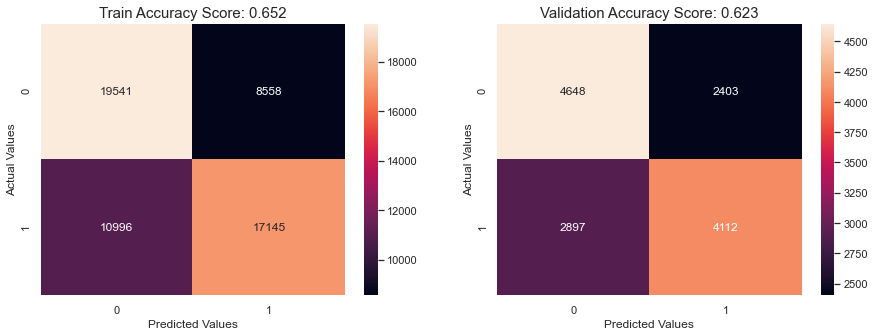

In [128]:
data_obj.confusion_mat(stack_tuned, X_train, X_val, y_train, y_val)

7. **Catboost on the PCA**

In [129]:
catb_pca =CatBoostClassifier(depth=4,iterations=500,learning_rate=0.1).fit(X_train_pca, y_train)

0:	learn: 0.6925467	total: 17ms	remaining: 8.48s
1:	learn: 0.6920568	total: 29.1ms	remaining: 7.26s
2:	learn: 0.6916080	total: 44.2ms	remaining: 7.32s
3:	learn: 0.6912485	total: 57.3ms	remaining: 7.1s
4:	learn: 0.6908232	total: 73ms	remaining: 7.23s
5:	learn: 0.6905795	total: 84.7ms	remaining: 6.98s
6:	learn: 0.6902756	total: 96.5ms	remaining: 6.79s
7:	learn: 0.6900668	total: 109ms	remaining: 6.68s
8:	learn: 0.6899096	total: 121ms	remaining: 6.59s
9:	learn: 0.6896978	total: 132ms	remaining: 6.47s
10:	learn: 0.6895537	total: 142ms	remaining: 6.32s
11:	learn: 0.6893592	total: 155ms	remaining: 6.3s
12:	learn: 0.6891878	total: 168ms	remaining: 6.3s
13:	learn: 0.6890684	total: 179ms	remaining: 6.2s
14:	learn: 0.6889497	total: 189ms	remaining: 6.1s
15:	learn: 0.6888287	total: 201ms	remaining: 6.09s
16:	learn: 0.6887022	total: 214ms	remaining: 6.09s
17:	learn: 0.6885801	total: 225ms	remaining: 6.03s
18:	learn: 0.6884751	total: 237ms	remaining: 6.01s
19:	learn: 0.6883406	total: 253ms	remaining

161:	learn: 0.6805863	total: 2.02s	remaining: 4.21s
162:	learn: 0.6805284	total: 2.03s	remaining: 4.2s
163:	learn: 0.6804750	total: 2.04s	remaining: 4.18s
164:	learn: 0.6804366	total: 2.05s	remaining: 4.17s
165:	learn: 0.6803695	total: 2.06s	remaining: 4.15s
166:	learn: 0.6803065	total: 2.08s	remaining: 4.14s
167:	learn: 0.6802220	total: 2.09s	remaining: 4.13s
168:	learn: 0.6801656	total: 2.1s	remaining: 4.12s
169:	learn: 0.6801101	total: 2.11s	remaining: 4.1s
170:	learn: 0.6800525	total: 2.13s	remaining: 4.09s
171:	learn: 0.6800034	total: 2.14s	remaining: 4.08s
172:	learn: 0.6799299	total: 2.15s	remaining: 4.06s
173:	learn: 0.6798760	total: 2.16s	remaining: 4.05s
174:	learn: 0.6798398	total: 2.17s	remaining: 4.04s
175:	learn: 0.6797929	total: 2.19s	remaining: 4.02s
176:	learn: 0.6797552	total: 2.2s	remaining: 4.01s
177:	learn: 0.6796994	total: 2.21s	remaining: 4s
178:	learn: 0.6796416	total: 2.22s	remaining: 3.98s
179:	learn: 0.6795892	total: 2.23s	remaining: 3.97s
180:	learn: 0.67953

321:	learn: 0.6732389	total: 4.02s	remaining: 2.22s
322:	learn: 0.6732022	total: 4.03s	remaining: 2.21s
323:	learn: 0.6731637	total: 4.05s	remaining: 2.2s
324:	learn: 0.6731297	total: 4.06s	remaining: 2.19s
325:	learn: 0.6730770	total: 4.07s	remaining: 2.17s
326:	learn: 0.6730339	total: 4.08s	remaining: 2.16s
327:	learn: 0.6730059	total: 4.09s	remaining: 2.15s
328:	learn: 0.6729646	total: 4.11s	remaining: 2.13s
329:	learn: 0.6729313	total: 4.12s	remaining: 2.12s
330:	learn: 0.6728577	total: 4.13s	remaining: 2.11s
331:	learn: 0.6728194	total: 4.14s	remaining: 2.1s
332:	learn: 0.6727796	total: 4.16s	remaining: 2.08s
333:	learn: 0.6727465	total: 4.17s	remaining: 2.07s
334:	learn: 0.6727001	total: 4.18s	remaining: 2.06s
335:	learn: 0.6726650	total: 4.19s	remaining: 2.05s
336:	learn: 0.6726228	total: 4.21s	remaining: 2.03s
337:	learn: 0.6725775	total: 4.22s	remaining: 2.02s
338:	learn: 0.6725275	total: 4.23s	remaining: 2.01s
339:	learn: 0.6724978	total: 4.24s	remaining: 2s
340:	learn: 0.672

490:	learn: 0.6667060	total: 6.2s	remaining: 114ms
491:	learn: 0.6666679	total: 6.22s	remaining: 101ms
492:	learn: 0.6666325	total: 6.23s	remaining: 88.5ms
493:	learn: 0.6666127	total: 6.24s	remaining: 75.8ms
494:	learn: 0.6665676	total: 6.26s	remaining: 63.2ms
495:	learn: 0.6665374	total: 6.28s	remaining: 50.6ms
496:	learn: 0.6665081	total: 6.29s	remaining: 38ms
497:	learn: 0.6664633	total: 6.3s	remaining: 25.3ms
498:	learn: 0.6664203	total: 6.31s	remaining: 12.7ms
499:	learn: 0.6663967	total: 6.33s	remaining: 0us


In [130]:
cbp_train_auc_base, cbp_val_auc_base,  cbp_train_auc, cbp_val_auc = \
data_obj.compare_parameters(" CATBOOST PCA", cat_model, catb_pca, X_train, X_val)

Baseline  CATBOOST PCA
Training AUC:0.690
Validation AUC:0.677
Optimized CATBOOST PCA
Training AUC:0.493
Validation AUC:0.495


**PCA** resulted in reduction in model auc. **Not to be used**

**Plot the tree** to give an overview of the model

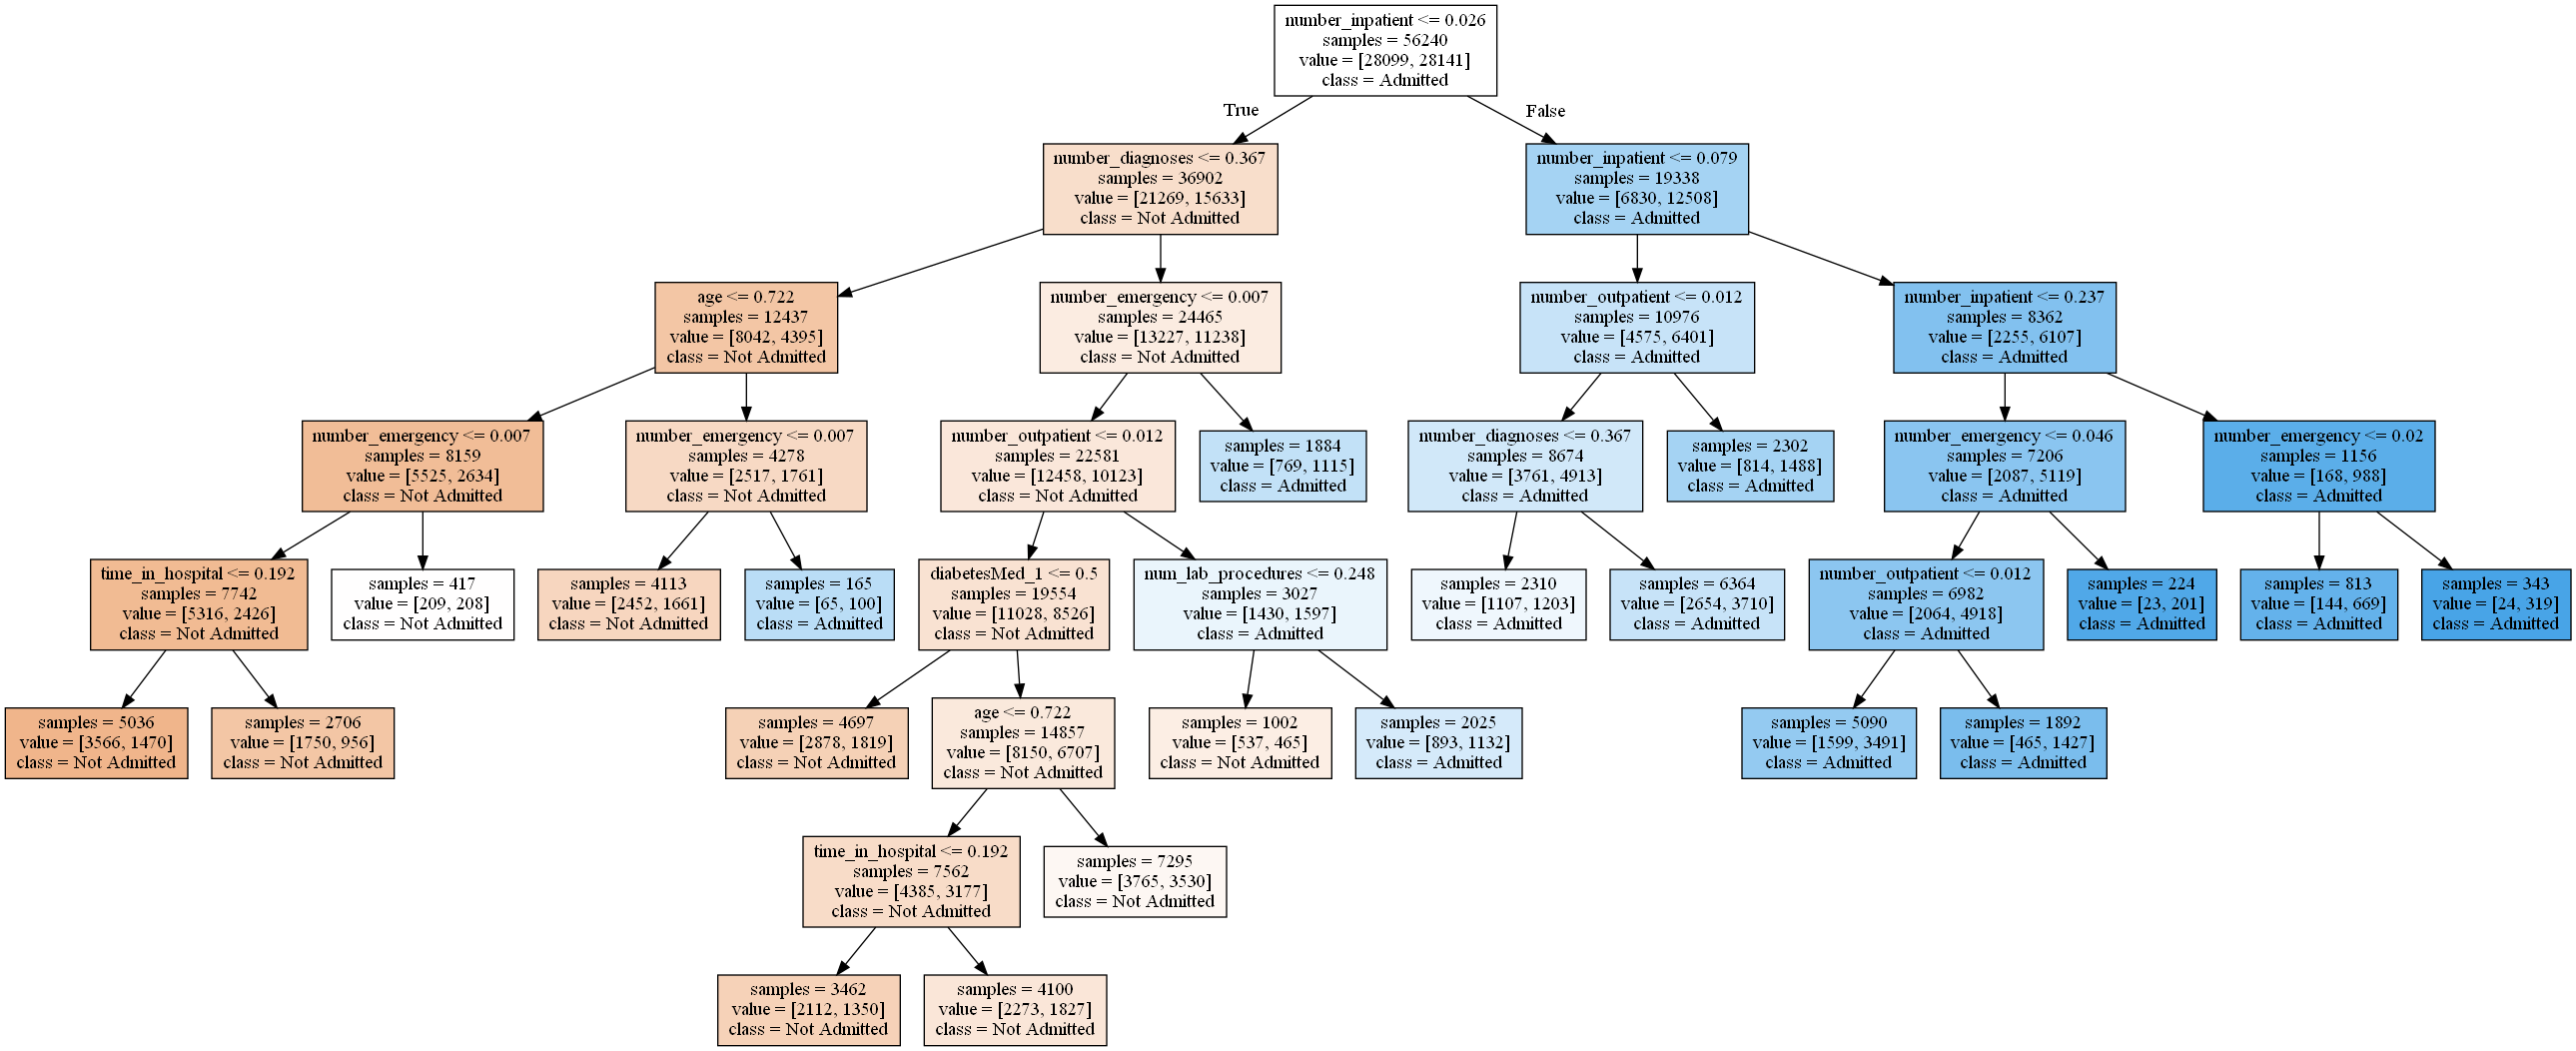

In [131]:
from IPython.display import Image  
from six import StringIO 
import pydotplus
from sklearn.tree import DecisionTreeClassifier, export_graphviz
dot_data = StringIO()  
export_graphviz(dc_tuned, out_file=dot_data, class_names=["Not Admitted", "Admitted"], feature_names=X_train.columns, impurity=False, filled=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

**Group the results together**

In [132]:

data_results = pd.DataFrame({'classifier':['RF','RF','CATB','CATB', 'DC', 'DC', "XGB", "XGB", "ADA",\
                                           "ADA", "SK", "Sk"],
                           'data_set':['base','optimized']*6,
                          'auc':[rf_val_auc_base,rf_val_auc,
                                 cb_val_auc_base,cb_val_auc,
                                dc_val_auc_base, dc_val_auc, 
                                 xgb_val_auc_base, xgb_val_auc, 
                                adt_val_auc_base, adt_val_auc,
                                st_val_auc_base, st_val_auc],
                          })
data_results 

classifier   data_set       auc
0          RF       base  0.657086
1          RF  optimized  0.668496
2        CATB       base  0.676971
3        CATB  optimized  0.677259
4          DC       base  0.646982
5          DC  optimized  0.651965
6         XGB       base  0.674297
7         XGB  optimized  0.675211
8         ADA       base  0.666609
9         ADA  optimized  0.666834
10         SK       base  0.675078
11         Sk  optimized  0.676042

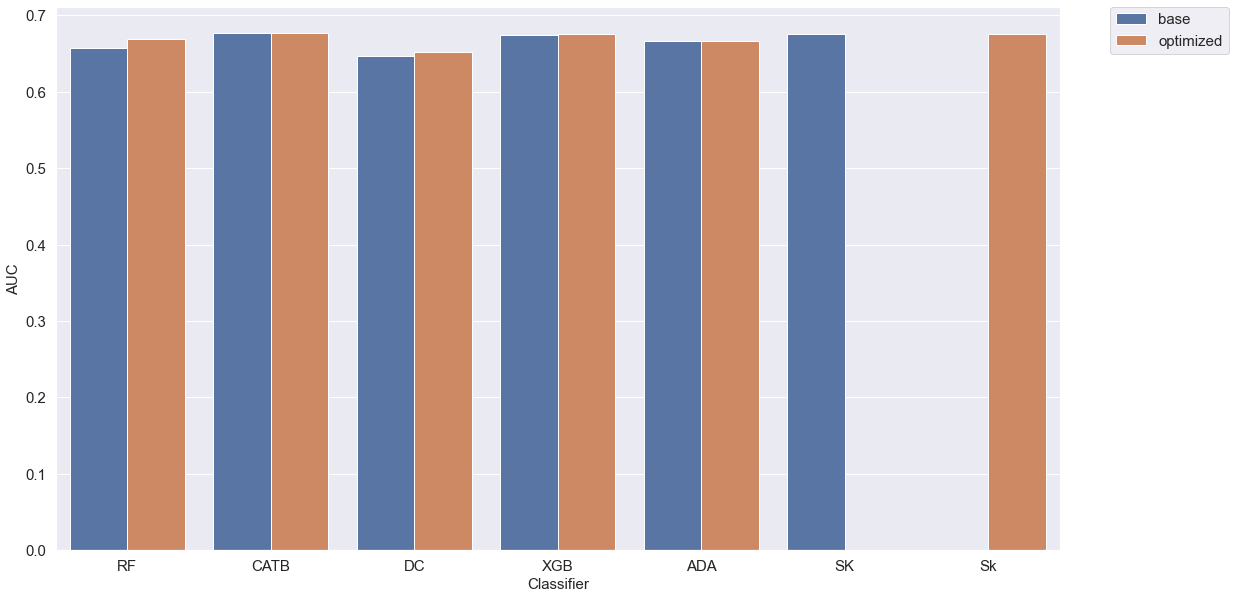

In [133]:
ax = sns.barplot(x="classifier", y="auc", hue="data_set", data=data_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15)
ax.tick_params(labelsize=15)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)

plt.show()

In [134]:
classifiers = [ rf_tuned,
                catb_tuned,
                  dc_tuned,
              xgb_tuned,
              ada_tuned,
              stack_tuned]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    yproba = cls.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)
result_table.sort_values('auc',ascending=False,inplace=True)

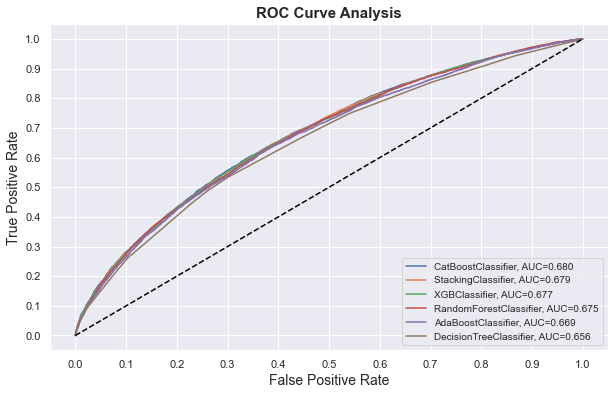

In [135]:
fig = plt.figure(figsize=(10,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='black', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=14)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=14)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':10}, loc='lower right')

plt.show()

In [136]:
classifiers = [ rf_tuned,
                catb_tuned,
                  dc_tuned,
              xgb_tuned,
              ada_tuned,
              stack_tuned]

# Define a result table as a DataFrame
test_result = pd.DataFrame(columns=['classifiers', 'accuracy','recall','auc'])
for cls in classifiers:
    y_test_preds = cls.predict_proba(X_test)[:,1]
    
    test_auc, test_accuracy, test_recall = data_obj.test_scores(y_test,y_test_preds, 0.5) # thresh = 0.5
    
    test_result = test_result.append({'classifiers':cls.__class__.__name__,
                                        'accuracy':test_accuracy, 
                                        'recall':test_recall, 
                                        'auc':test_auc}, ignore_index=True)


# Set name of the classifiers as index labels
test_result.set_index('classifiers', inplace=True)
test_result.sort_values('auc',ascending=False,inplace=True)


In [137]:
import plotly.graph_objs as go

trace1=go.Bar(
                x=test_result.index,
                y=test_result.accuracy,
                name="Accuracy",
                marker= dict(color = 'rgba(100, 20, 30, 0.7)',
                            line=dict(color='rgb(0,0,0)',width=1.9)),
                text=round(test_result.accuracy,3),textposition='auto')
trace2=go.Bar(
                x=test_result.index,
                y=test_result.recall,
                name="Recall",
                marker=dict(color = 'rgba(56, 140, 200, 0.7)',
                           line=dict(color='rgb(0,0,0)',width=1.9)),
                text=round(test_result.recall,3),textposition='auto')
trace3=go.Bar(
                x=test_result.index,
                y=test_result.auc,
                name="AUC",
                marker=dict(color = 'rgba(120, 180, 20, 0.7)',
                           line=dict(color='rgb(0,0,0)',width=1.9)),
                text=round(test_result.auc,3),textposition='auto')

edit_df=[trace1,trace2,trace3]
layout = { 'barmode':'group',
           'title_text':'Accuracy, Recall and AUC Plot Readmitted' }

fig= go.Figure(data=edit_df,layout=layout)
#plt.savefig('graph.png')
fig.show()

In [138]:
best_model = catb_tuned

y_train_preds = best_model.predict_proba(X_train)[:,1]
y_valid_preds = best_model.predict_proba(X_val)[:,1]
y_test_preds = best_model.predict_proba(X_test)[:,1]

In [139]:

print('Training:')
train_auc, train_accuracy, train_recall, train_precision, train_fscore, train_specificity = data_obj.model_report(y_train,y_train_preds, thresh)
print('Validation:')
val_auc, val_accuracy, val_recall, val_precision, val_fscore,val_specificity = data_obj.model_report(y_val,y_val_preds, thresh)
print('Test:')
test_auc, test_accuracy, test_recall, test_precision, test_fscore, test_specificity = data_obj.model_report(y_test,y_test_preds, thresh)

Training:
AUC:0.701
accuracy:0.643
recall:0.600
precision:0.656
fscore:0.627
specificity:0.685
 
Validation:
AUC:0.675
accuracy:0.625
recall:0.579
precision:0.636
fscore:0.606
specificity:0.671
 
Test:
AUC:0.680
accuracy:0.632
recall:0.587
precision:0.605
fscore:0.596
specificity:0.672
 


In [140]:
import shap
shap.initjs()

In [141]:
explainer = shap.TreeExplainer(catb_tuned)
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

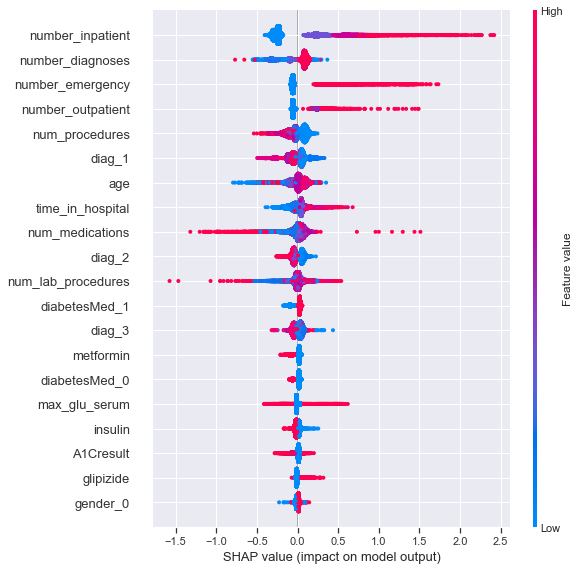

In [142]:
#shap.force_plot(explainer.expected_value, shap_values, X_test)
shap.summary_plot(shap_values, X_test)